In [1]:
!pip install -q catboost
!pip install -q geopy
!pip install -q eli5

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
import ipywidgets
from tqdm import tqdm

import os

import scipy
import eli5
plt.rcParams['figure.figsize'] = [12, 6]
pd.set_option('display.max_rows', 500)

%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Using TensorFlow backend.


# Metrics

In [2]:
import typing
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error

THRESHOLD = 0.15
NEGATIVE_WEIGHT = 1.1

def deviation_metric_one_sample(y_true: typing.Union[float, int], y_pred: typing.Union[float, int]) -> float:
    """
    Реализация кастомной метрики для хакатона.

    :param y_true: float, реальная цена
    :param y_pred: float, предсказанная цена
    :return: float, значение метрики
    """
    deviation = (y_pred - y_true) / np.maximum(1e-8, y_true)
    if np.abs(deviation) <= THRESHOLD:
        return 0
    elif deviation <= - 4 * THRESHOLD:
        return 9 * NEGATIVE_WEIGHT
    elif deviation < -THRESHOLD:
        return NEGATIVE_WEIGHT * ((deviation / THRESHOLD) + 1) ** 2
    elif deviation < 4 * THRESHOLD:
        return ((deviation / THRESHOLD) - 1) ** 2
    else:
        return 9


def deviation_metric(y_true, y_pred, isLog=False) -> float:
    if isLog:
        y_pred = np.exp(y_pred)
        y_true = np.exp(y_true)
    return np.array([deviation_metric_one_sample(y_true[n], y_pred[n]) for n in range(len(y_true))]).mean()

def median_absolute_percentage_error(y_true: np.array, y_pred: np.array) -> float:
    return np.median(np.abs(y_pred-y_true)/y_true)

def metrics_stat(y_true: np.array, y_pred: np.array) -> typing.Dict[str,float]:
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mdape = median_absolute_percentage_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    raif_metric = deviation_metric(y_true, y_pred)
    return {'mape':mape, 'mdape':mdape, 'rmse': rmse, 'r2': r2, 'raif_metric':raif_metric}

EPS = 1e-8
assert deviation_metric(np.array([1,2,3,4,5]),np.array([1,2,3,4,5])) <= EPS
assert deviation_metric(np.array([1,2,3,4,5]),np.array([0.9,1.8,2.7,3.6,4.5])) <= EPS
assert deviation_metric(np.array([1,2,3,4,5]),np.array([1.1,2.2,3.3,4.4,5.5])) <= EPS
assert deviation_metric(np.array([1,2,3,4,5]),np.array([1.15,2.3,3.45,4.6,5.75])) <= EPS
assert np.abs(deviation_metric(np.array([1,2,3,4,5]),np.array([1.3,2.6,3.9,5.2,6.5]))-1) <= EPS
assert np.abs(deviation_metric(np.array([1,2,3,4,5]),np.array([0.7,1.4,2.1,2.8,3.5]))-1*NEGATIVE_WEIGHT) <= EPS
assert np.abs(deviation_metric(np.array([1,2,3,4,5]),np.array([10,20,30,40,50]))-9) <= EPS
assert np.abs(deviation_metric(np.array([1,2,3,4,5]),np.array([0,0,0,0,0]))-9*NEGATIVE_WEIGHT) <= EPS
assert np.abs(deviation_metric(np.array([1,2,3,4,5]),np.array([1,2.2,3.3,5,50])) - 85/45) <= EPS

# Load data


In [3]:
starting_data = pd.read_csv('data/train.csv', index_col='id')

C:\Users\ukhin\.conda\envs\PythonGPU\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
starting_data = starting_data.reindex(columns=sorted(starting_data.columns))

# Features

### drop some features 

In [5]:
df_DateOut = starting_data.drop(['date'], axis = 1)

### make feature from 'floor' column 

In [6]:
def set_floor(str):
    ans = []
    try:
        s = float(str)
        if s<0:
            return '-1'
        if s == 1:
            return '1'
        if s==2:
            return '2'
        if s<5:
            return '3'
        if s<10:
            return '4'
        if s<20:
            return '5'
        if s<50:
            return '6'
        if s<90:
            return '7'
        else:
            return '0'
        
    except:
        if 'подвал' in str.lower() :
            return 'подвал'
        if 'цоколь' in str.lower() :
            return 'цоколь'
        else:
            return 'uknown'

In [7]:
df_CatFloor_DateOut = df_DateOut
df_CatFloor_DateOut['floor'] = df_CatFloor_DateOut['floor'].apply(str)
df_CatFloor_DateOut['floor'] = df_CatFloor_DateOut['floor'].apply(set_floor)

### categorical features 

In [9]:
cat_features = set([df_CatFloor_DateOut.columns[i] for i in range(len(df_CatFloor_DateOut.dtypes)) if str(df_CatFloor_DateOut.dtypes[i]) not in ['float64','float32', 'int64']])

cat_features.add(df_CatFloor_DateOut.columns[list(df_CatFloor_DateOut.columns).index('realty_type')])
df_CatFloor_DateOut['realty_type']= df_CatFloor_DateOut['realty_type'].apply(str)
cat_features.add(df_CatFloor_DateOut.columns[list(df_CatFloor_DateOut.columns).index('floor')])

cat_features

### dropna 

In [13]:
for col in df_CatFloor_DateOut.columns:
    if col not in cat_features:
        df_CatFloor_DateOut[col] = df_CatFloor_DateOut[col].fillna(df_CatFloor_DateOut[col].median())
    else:
        df_CatFloor_DateOut[col] = df_CatFloor_DateOut[col].fillna('unknown')

### Logarithms

Посмотрим на распределения общей площади площади и цены за квадратный метр

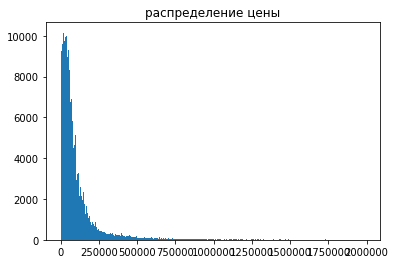

In [14]:
fig = plt.hist(df_CatFloor_DateOut.per_square_meter_price, bins=500)
t = plt.title('распределение цены')

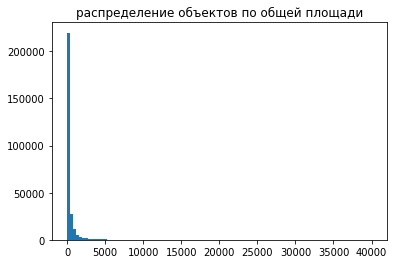

In [15]:
fig = plt.hist(df_CatFloor_DateOut.total_square, bins=100)
t = plt.title('распределение объектов по общей площади')

Это распределение напоминает логнормальное. Возьмем теперь логарифм от этих колонок.

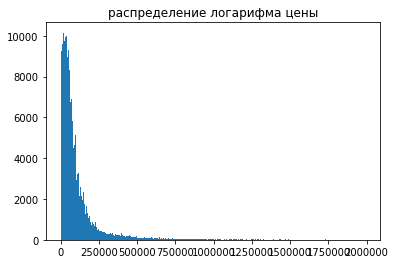

In [16]:
fig = plt.hist(df_CatFloor_DateOut.per_square_meter_price, bins=500)
t = plt.title('распределение логарифма цены')

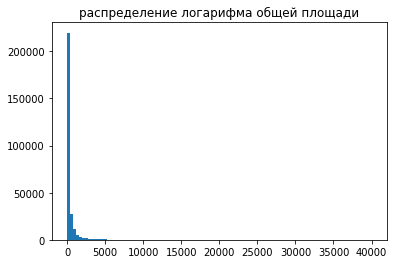

In [17]:
fig = plt.hist(df_CatFloor_DateOut.total_square, bins=100)
t = plt.title('распределение логарифма общей площади')

Поэтому, вместо цены будем тренироваться на логарифме цены, а также добавим колонку с логарифмом площади.

In [30]:
df_logSquare_CatFloor_DateOut = df_CatFloor_DateOut.merge(pd.DataFrame({'total_square_log':np.log(df_CatFloor_DateOut.total_square)}),\
              on=df_CatFloor_DateOut.index)
df_logSquare_CatFloor_DateOut = df_logSquare_CatFloor_DateOut.rename({'key_0':'id'}, axis=1)
df_logSquare_CatFloor_DateOut.index = df_logSquare_CatFloor_DateOut.id
df_logSquare_CatFloor_DateOut.drop(['id'], axis=1, inplace=True)
log_pr = df_logSquare_CatFloor_DateOut.per_square_meter_price.apply(np.log)
df_logPrice_logSquare_CatFloor_DateOut = df_logSquare_CatFloor_DateOut
df_logPrice_logSquare_CatFloor_DateOut['per_square_meter_price'] = log_pr
main_df_price1 = df_logPrice_logSquare_CatFloor_DateOut.loc[df_logSquare_CatFloor_DateOut.price_type == 1].drop(['price_type'], axis = 1)
main_df_price0 = df_logPrice_logSquare_CatFloor_DateOut.loc[df_logSquare_CatFloor_DateOut.price_type == 0].drop(['price_type'], axis = 1)

# Experiments

## Cross validation 

In [34]:
def cross_validate(data, iterations, cat_features, verbose, n_cv, unused_features):
    data.drop(unused_features, axis=1, inplace=True)
    diff = set(unused_features)
    cat_features.difference_update(diff)
    
    catboost_regressor = CatBoostRegressor(iterations=iterations,cat_features=cat_features, random_seed=17, task_type=task_type)
    
    idxs = [[] for i in range(n_cv)]
    for i in range(len(data)):
        r = np.random.randint(0, n_cv)
        idxs[r].append(data.index[i])
    X_train = pd.DataFrame()
    X_test  = pd.DataFrame()
    y_train = pd.DataFrame()
    y_test  = pd.DataFrame()
    scores = []
    feature_imp_lst = []
    for i in range(len(idxs)):
        print('Iter: ', i)
        train_idxs = []
        for idx in idxs[:i]+idxs[i+1:]:
            train_idxs+=idx
        X_train =  data.loc[train_idxs, :].drop('per_square_meter_price', axis=1)
        X_test  =  data.loc[idxs[i]].drop('per_square_meter_price', axis=1)
        y_train =  data.loc[train_idxs, :].per_square_meter_price
        y_test  =  data.loc[idxs[i], :].per_square_meter_price
        catboost_regressor.fit(X_train, y_train, verbose=verbose, plot=True)
        y_pred = catboost_regressor.predict(X_test)
        score = deviation_metric(y_test, y_pred, isLog=True)
        scores.append(score)
        feature_imp_lst.append(catboost_regressor.feature_importances_)
        print("Score: ", score)   
    print('Score: ', sum(scores)/len(scores))
    feature_imps = []
    for i in range(len(sum(feature_imp_lst)/len(feature_imp_lst))):
        feature_imps.append((X_train.columns[i], catboost_regressor.feature_importances_[i]))
    feature_imps = sorted(feature_imps, key = lambda x: x[1])
    feature_imps.reverse()
    print('Feature importances')
    print(feature_imps)

### Only '1' class, log price, log total square

In [35]:
iterations=1000
task_type="GPU"
verbose=1
n_cv = 4
unused_features = ['total_square']
data = main_df_price1.copy()
cross_validate(data, iterations, cat_features, verbose, n_cv, unused_features)


Iter:  0


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5750171	total: 19.5ms	remaining: 1.93s
1:	learn: 0.5663226	total: 27.3ms	remaining: 1.34s
2:	learn: 0.5577699	total: 36.1ms	remaining: 1.17s
3:	learn: 0.5496957	total: 45.4ms	remaining: 1.09s
4:	learn: 0.5417520	total: 54.7ms	remaining: 1.04s
5:	learn: 0.5345432	total: 64.2ms	remaining: 1s
6:	learn: 0.5272297	total: 72.9ms	remaining: 968ms
7:	learn: 0.5202512	total: 82ms	remaining: 943ms
8:	learn: 0.5136352	total: 92ms	remaining: 930ms
9:	learn: 0.5073038	total: 101ms	remaining: 907ms
10:	learn: 0.5012071	total: 110ms	remaining: 890ms
11:	learn: 0.4951637	total: 118ms	remaining: 868ms
12:	learn: 0.4899320	total: 127ms	remaining: 853ms
13:	learn: 0.4843479	total: 138ms	remaining: 849ms
14:	learn: 0.4790257	total: 148ms	remaining: 836ms
15:	learn: 0.4740920	total: 157ms	remaining: 824ms
16:	learn: 0.4694124	total: 167ms	remaining: 816ms
17:	learn: 0.4646954	total: 179ms	remaining: 813ms
18:	learn: 0.4600969	total: 188ms	remaining: 801ms
19:	learn: 0.4559011	total: 198ms	remai

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5767051	total: 10.1ms	remaining: 997ms
1:	learn: 0.5681099	total: 18.5ms	remaining: 907ms
2:	learn: 0.5597125	total: 27.3ms	remaining: 882ms
3:	learn: 0.5521996	total: 35.9ms	remaining: 863ms
4:	learn: 0.5446199	total: 45.6ms	remaining: 866ms
5:	learn: 0.5375092	total: 55.6ms	remaining: 871ms
6:	learn: 0.5305429	total: 65.5ms	remaining: 870ms
7:	learn: 0.5238055	total: 75.5ms	remaining: 868ms
8:	learn: 0.5170178	total: 84.8ms	remaining: 858ms
9:	learn: 0.5108151	total: 93.2ms	remaining: 839ms
10:	learn: 0.5047161	total: 102ms	remaining: 826ms
11:	learn: 0.4989500	total: 110ms	remaining: 810ms
12:	learn: 0.4933410	total: 121ms	remaining: 811ms
13:	learn: 0.4880094	total: 131ms	remaining: 807ms
14:	learn: 0.4827053	total: 139ms	remaining: 790ms
15:	learn: 0.4777210	total: 148ms	remaining: 775ms
16:	learn: 0.4730264	total: 157ms	remaining: 767ms
17:	learn: 0.4686649	total: 166ms	remaining: 756ms
18:	learn: 0.4642150	total: 177ms	remaining: 756ms
19:	learn: 0.4603723	total: 187

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5865847	total: 8.34ms	remaining: 826ms
1:	learn: 0.5775528	total: 15.5ms	remaining: 757ms
2:	learn: 0.5687799	total: 22.6ms	remaining: 731ms
3:	learn: 0.5602702	total: 30.3ms	remaining: 727ms
4:	learn: 0.5522171	total: 38.5ms	remaining: 731ms
5:	learn: 0.5443643	total: 46.1ms	remaining: 722ms
6:	learn: 0.5368165	total: 53.4ms	remaining: 709ms
7:	learn: 0.5296423	total: 61.9ms	remaining: 712ms
8:	learn: 0.5226667	total: 74ms	remaining: 748ms
9:	learn: 0.5161320	total: 83.3ms	remaining: 750ms
10:	learn: 0.5096899	total: 91.6ms	remaining: 741ms
11:	learn: 0.5034040	total: 102ms	remaining: 747ms
12:	learn: 0.4974677	total: 110ms	remaining: 736ms
13:	learn: 0.4916754	total: 119ms	remaining: 728ms
14:	learn: 0.4860767	total: 128ms	remaining: 723ms
15:	learn: 0.4808887	total: 137ms	remaining: 721ms
16:	learn: 0.4757937	total: 149ms	remaining: 729ms
17:	learn: 0.4709221	total: 165ms	remaining: 751ms
18:	learn: 0.4662485	total: 180ms	remaining: 767ms
19:	learn: 0.4619781	total: 192m

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5741051	total: 7.41ms	remaining: 734ms
1:	learn: 0.5655447	total: 14.5ms	remaining: 713ms
2:	learn: 0.5570116	total: 22.1ms	remaining: 714ms
3:	learn: 0.5488244	total: 29.1ms	remaining: 698ms
4:	learn: 0.5411542	total: 35.9ms	remaining: 682ms
5:	learn: 0.5337444	total: 43.1ms	remaining: 674ms
6:	learn: 0.5267023	total: 51.9ms	remaining: 690ms
7:	learn: 0.5197242	total: 59.4ms	remaining: 683ms
8:	learn: 0.5129726	total: 69.1ms	remaining: 699ms
9:	learn: 0.5063681	total: 76.5ms	remaining: 689ms
10:	learn: 0.5002847	total: 84ms	remaining: 680ms
11:	learn: 0.4943548	total: 93.3ms	remaining: 684ms
12:	learn: 0.4888689	total: 102ms	remaining: 681ms
13:	learn: 0.4835930	total: 109ms	remaining: 672ms
14:	learn: 0.4781712	total: 117ms	remaining: 661ms
15:	learn: 0.4732629	total: 125ms	remaining: 654ms
16:	learn: 0.4683754	total: 133ms	remaining: 649ms
17:	learn: 0.4637116	total: 141ms	remaining: 643ms
18:	learn: 0.4591483	total: 148ms	remaining: 631ms
19:	learn: 0.4546549	total: 158

[('city', 24.2631624800222), ('total_square_log', 15.495923733881233), ('osm_catering_points_in_0.005', 6.553115949195958), ('region', 5.940963241409886), ('osm_catering_points_in_0.0075', 5.821228207728914), ('osm_catering_points_in_0.01', 5.419130326605461), ('osm_city_nearest_name', 3.60849560157936), ('osm_hotels_points_in_0.0075', 3.2809820150287012), ('floor', 2.5905871623537893), ('osm_subway_closest_dist', 2.4572966229406115), ('osm_amenity_points_in_0.001', 2.3161709070432717), ('realty_type', 2.2920691823492305), ('reform_mean_floor_count_500', 1.9080870905293306), ('osm_crossing_points_in_0.01', 1.1823437340401248), ('osm_crossing_closest_dist', 1.136965687127358), ('osm_city_closest_dist', 1.0528261832095998), ('osm_amenity_points_in_0.01', 0.9253039467439889), ('osm_city_nearest_population', 0.9206208594936277), ('osm_hotels_points_in_0.01', 0.8831268517133736), ('osm_catering_points_in_0.001', 0.8004935365044173), ('reform_house_population_1000', 0.7924484786648074), ('os

# Fitting

In [59]:
iterations=12000
task_type="GPU"
verbose=1
unused_features = ['total_square']
data = main_df_price1.copy()
data.drop(unused_features, axis=1, inplace=True)
diff = set(unused_features)
cat_features.difference_update(diff)
catboost_regressor = CatBoostRegressor(iterations=iterations,cat_features=cat_features, random_seed=17, task_type=task_type)
X_train =  data.drop('per_square_meter_price', axis=1)
y_train =  data.per_square_meter_price
catboost_regressor.fit(X_train, y_train, verbose=verbose, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5779275	total: 42ms	remaining: 8m 24s
1:	learn: 0.5694068	total: 83.7ms	remaining: 8m 21s
2:	learn: 0.5610078	total: 125ms	remaining: 8m 18s
3:	learn: 0.5529007	total: 169ms	remaining: 8m 26s
4:	learn: 0.5451131	total: 207ms	remaining: 8m 17s
5:	learn: 0.5377181	total: 247ms	remaining: 8m 12s
6:	learn: 0.5301237	total: 288ms	remaining: 8m 12s
7:	learn: 0.5230529	total: 328ms	remaining: 8m 11s
8:	learn: 0.5164240	total: 364ms	remaining: 8m 4s
9:	learn: 0.5102107	total: 402ms	remaining: 8m 2s
10:	learn: 0.5039066	total: 440ms	remaining: 7m 59s
11:	learn: 0.4977915	total: 474ms	remaining: 7m 53s
12:	learn: 0.4923780	total: 513ms	remaining: 7m 52s
13:	learn: 0.4869329	total: 550ms	remaining: 7m 51s
14:	learn: 0.4815483	total: 592ms	remaining: 7m 53s
15:	learn: 0.4765035	total: 631ms	remaining: 7m 52s
16:	learn: 0.4717600	total: 676ms	remaining: 7m 56s
17:	learn: 0.4669076	total: 741ms	remaining: 8m 13s
18:	learn: 0.4623722	total: 786ms	remaining: 8m 15s
19:	learn: 0.4581221	tot

159:	learn: 0.3289953	total: 5.69s	remaining: 7m
160:	learn: 0.3287519	total: 5.72s	remaining: 7m
161:	learn: 0.3285996	total: 5.75s	remaining: 7m
162:	learn: 0.3283569	total: 5.78s	remaining: 6m 59s
163:	learn: 0.3281155	total: 5.81s	remaining: 6m 59s
164:	learn: 0.3279081	total: 5.84s	remaining: 6m 58s
165:	learn: 0.3276519	total: 5.87s	remaining: 6m 58s
166:	learn: 0.3274202	total: 5.9s	remaining: 6m 58s
167:	learn: 0.3273613	total: 5.93s	remaining: 6m 57s
168:	learn: 0.3271905	total: 5.96s	remaining: 6m 57s
169:	learn: 0.3269984	total: 5.99s	remaining: 6m 57s
170:	learn: 0.3268867	total: 6.02s	remaining: 6m 56s
171:	learn: 0.3267565	total: 6.06s	remaining: 6m 56s
172:	learn: 0.3266142	total: 6.09s	remaining: 6m 56s
173:	learn: 0.3264419	total: 6.12s	remaining: 6m 56s
174:	learn: 0.3262194	total: 6.15s	remaining: 6m 55s
175:	learn: 0.3261015	total: 6.18s	remaining: 6m 55s
176:	learn: 0.3259607	total: 6.21s	remaining: 6m 54s
177:	learn: 0.3256934	total: 6.24s	remaining: 6m 54s
178:	l

315:	learn: 0.3090459	total: 10.8s	remaining: 6m 39s
316:	learn: 0.3089618	total: 10.8s	remaining: 6m 39s
317:	learn: 0.3088671	total: 10.9s	remaining: 6m 38s
318:	learn: 0.3085881	total: 10.9s	remaining: 6m 38s
319:	learn: 0.3085035	total: 10.9s	remaining: 6m 38s
320:	learn: 0.3084210	total: 11s	remaining: 6m 38s
321:	learn: 0.3082927	total: 11s	remaining: 6m 38s
322:	learn: 0.3082112	total: 11s	remaining: 6m 38s
323:	learn: 0.3081607	total: 11.1s	remaining: 6m 38s
324:	learn: 0.3080969	total: 11.1s	remaining: 6m 38s
325:	learn: 0.3080774	total: 11.1s	remaining: 6m 38s
326:	learn: 0.3078562	total: 11.1s	remaining: 6m 37s
327:	learn: 0.3077266	total: 11.2s	remaining: 6m 37s
328:	learn: 0.3076066	total: 11.2s	remaining: 6m 37s
329:	learn: 0.3075066	total: 11.2s	remaining: 6m 37s
330:	learn: 0.3074521	total: 11.3s	remaining: 6m 37s
331:	learn: 0.3073530	total: 11.3s	remaining: 6m 37s
332:	learn: 0.3072716	total: 11.3s	remaining: 6m 37s
333:	learn: 0.3072408	total: 11.4s	remaining: 6m 37s

471:	learn: 0.2980388	total: 15.7s	remaining: 6m 22s
472:	learn: 0.2979769	total: 15.7s	remaining: 6m 22s
473:	learn: 0.2979713	total: 15.7s	remaining: 6m 22s
474:	learn: 0.2979490	total: 15.8s	remaining: 6m 22s
475:	learn: 0.2978592	total: 15.8s	remaining: 6m 22s
476:	learn: 0.2978053	total: 15.8s	remaining: 6m 22s
477:	learn: 0.2977998	total: 15.9s	remaining: 6m 22s
478:	learn: 0.2977925	total: 15.9s	remaining: 6m 22s
479:	learn: 0.2976947	total: 15.9s	remaining: 6m 22s
480:	learn: 0.2976664	total: 15.9s	remaining: 6m 21s
481:	learn: 0.2976505	total: 16s	remaining: 6m 21s
482:	learn: 0.2974430	total: 16s	remaining: 6m 21s
483:	learn: 0.2974304	total: 16s	remaining: 6m 21s
484:	learn: 0.2972495	total: 16.1s	remaining: 6m 21s
485:	learn: 0.2972146	total: 16.1s	remaining: 6m 21s
486:	learn: 0.2970941	total: 16.1s	remaining: 6m 21s
487:	learn: 0.2970379	total: 16.2s	remaining: 6m 21s
488:	learn: 0.2970105	total: 16.2s	remaining: 6m 21s
489:	learn: 0.2968248	total: 16.2s	remaining: 6m 21s

627:	learn: 0.2889060	total: 20.6s	remaining: 6m 12s
628:	learn: 0.2888405	total: 20.6s	remaining: 6m 12s
629:	learn: 0.2888262	total: 20.6s	remaining: 6m 12s
630:	learn: 0.2888144	total: 20.6s	remaining: 6m 12s
631:	learn: 0.2887780	total: 20.7s	remaining: 6m 12s
632:	learn: 0.2886400	total: 20.7s	remaining: 6m 11s
633:	learn: 0.2886068	total: 20.7s	remaining: 6m 11s
634:	learn: 0.2886036	total: 20.8s	remaining: 6m 11s
635:	learn: 0.2885419	total: 20.8s	remaining: 6m 11s
636:	learn: 0.2884863	total: 20.8s	remaining: 6m 11s
637:	learn: 0.2884813	total: 20.9s	remaining: 6m 11s
638:	learn: 0.2884472	total: 20.9s	remaining: 6m 11s
639:	learn: 0.2884107	total: 20.9s	remaining: 6m 11s
640:	learn: 0.2884059	total: 21s	remaining: 6m 11s
641:	learn: 0.2883058	total: 21s	remaining: 6m 11s
642:	learn: 0.2882950	total: 21s	remaining: 6m 11s
643:	learn: 0.2882251	total: 21s	remaining: 6m 11s
644:	learn: 0.2882220	total: 21.1s	remaining: 6m 11s
645:	learn: 0.2882106	total: 21.1s	remaining: 6m 11s
6

785:	learn: 0.2803442	total: 25.5s	remaining: 6m 3s
786:	learn: 0.2803131	total: 25.5s	remaining: 6m 3s
787:	learn: 0.2803001	total: 25.5s	remaining: 6m 3s
788:	learn: 0.2802983	total: 25.6s	remaining: 6m 3s
789:	learn: 0.2802940	total: 25.6s	remaining: 6m 3s
790:	learn: 0.2802176	total: 25.6s	remaining: 6m 2s
791:	learn: 0.2801404	total: 25.6s	remaining: 6m 2s
792:	learn: 0.2800322	total: 25.7s	remaining: 6m 2s
793:	learn: 0.2799807	total: 25.7s	remaining: 6m 2s
794:	learn: 0.2799296	total: 25.7s	remaining: 6m 2s
795:	learn: 0.2799164	total: 25.8s	remaining: 6m 2s
796:	learn: 0.2799072	total: 25.8s	remaining: 6m 2s
797:	learn: 0.2797783	total: 25.8s	remaining: 6m 2s
798:	learn: 0.2796804	total: 25.9s	remaining: 6m 2s
799:	learn: 0.2796144	total: 25.9s	remaining: 6m 2s
800:	learn: 0.2795841	total: 25.9s	remaining: 6m 2s
801:	learn: 0.2795667	total: 26s	remaining: 6m 2s
802:	learn: 0.2795610	total: 26s	remaining: 6m 2s
803:	learn: 0.2794346	total: 26s	remaining: 6m 2s
804:	learn: 0.2794

943:	learn: 0.2740324	total: 30.4s	remaining: 5m 55s
944:	learn: 0.2739712	total: 30.4s	remaining: 5m 55s
945:	learn: 0.2739645	total: 30.5s	remaining: 5m 55s
946:	learn: 0.2739173	total: 30.5s	remaining: 5m 55s
947:	learn: 0.2738618	total: 30.5s	remaining: 5m 55s
948:	learn: 0.2738610	total: 30.5s	remaining: 5m 55s
949:	learn: 0.2738162	total: 30.6s	remaining: 5m 55s
950:	learn: 0.2737694	total: 30.6s	remaining: 5m 55s
951:	learn: 0.2737531	total: 30.6s	remaining: 5m 55s
952:	learn: 0.2736989	total: 30.7s	remaining: 5m 55s
953:	learn: 0.2736772	total: 30.7s	remaining: 5m 55s
954:	learn: 0.2736576	total: 30.7s	remaining: 5m 55s
955:	learn: 0.2736290	total: 30.8s	remaining: 5m 55s
956:	learn: 0.2736284	total: 30.8s	remaining: 5m 55s
957:	learn: 0.2735985	total: 30.8s	remaining: 5m 55s
958:	learn: 0.2735979	total: 30.9s	remaining: 5m 55s
959:	learn: 0.2735332	total: 30.9s	remaining: 5m 55s
960:	learn: 0.2734520	total: 30.9s	remaining: 5m 55s
961:	learn: 0.2734487	total: 31s	remaining: 5m

1097:	learn: 0.2698987	total: 35.1s	remaining: 5m 48s
1098:	learn: 0.2698929	total: 35.2s	remaining: 5m 48s
1099:	learn: 0.2698091	total: 35.2s	remaining: 5m 48s
1100:	learn: 0.2697939	total: 35.2s	remaining: 5m 48s
1101:	learn: 0.2697901	total: 35.2s	remaining: 5m 48s
1102:	learn: 0.2697853	total: 35.3s	remaining: 5m 48s
1103:	learn: 0.2697818	total: 35.3s	remaining: 5m 48s
1104:	learn: 0.2697499	total: 35.3s	remaining: 5m 48s
1105:	learn: 0.2696876	total: 35.4s	remaining: 5m 48s
1106:	learn: 0.2696788	total: 35.4s	remaining: 5m 48s
1107:	learn: 0.2696750	total: 35.4s	remaining: 5m 48s
1108:	learn: 0.2696706	total: 35.5s	remaining: 5m 48s
1109:	learn: 0.2696672	total: 35.5s	remaining: 5m 48s
1110:	learn: 0.2696595	total: 35.5s	remaining: 5m 48s
1111:	learn: 0.2696560	total: 35.6s	remaining: 5m 48s
1112:	learn: 0.2696009	total: 35.6s	remaining: 5m 48s
1113:	learn: 0.2695958	total: 35.6s	remaining: 5m 48s
1114:	learn: 0.2695924	total: 35.6s	remaining: 5m 47s
1115:	learn: 0.2695695	total

1250:	learn: 0.2655942	total: 40.2s	remaining: 5m 45s
1251:	learn: 0.2654984	total: 40.3s	remaining: 5m 45s
1252:	learn: 0.2654913	total: 40.3s	remaining: 5m 45s
1253:	learn: 0.2654744	total: 40.4s	remaining: 5m 45s
1254:	learn: 0.2654421	total: 40.4s	remaining: 5m 45s
1255:	learn: 0.2653833	total: 40.4s	remaining: 5m 45s
1256:	learn: 0.2653777	total: 40.5s	remaining: 5m 45s
1257:	learn: 0.2653652	total: 40.5s	remaining: 5m 45s
1258:	learn: 0.2653299	total: 40.5s	remaining: 5m 45s
1259:	learn: 0.2653157	total: 40.6s	remaining: 5m 45s
1260:	learn: 0.2652926	total: 40.6s	remaining: 5m 45s
1261:	learn: 0.2652598	total: 40.6s	remaining: 5m 45s
1262:	learn: 0.2651417	total: 40.6s	remaining: 5m 45s
1263:	learn: 0.2650896	total: 40.7s	remaining: 5m 45s
1264:	learn: 0.2650708	total: 40.7s	remaining: 5m 45s
1265:	learn: 0.2650703	total: 40.7s	remaining: 5m 45s
1266:	learn: 0.2650460	total: 40.8s	remaining: 5m 45s
1267:	learn: 0.2650212	total: 40.8s	remaining: 5m 45s
1268:	learn: 0.2650105	total

1403:	learn: 0.2610490	total: 45.5s	remaining: 5m 43s
1404:	learn: 0.2610459	total: 45.5s	remaining: 5m 43s
1405:	learn: 0.2610430	total: 45.5s	remaining: 5m 43s
1406:	learn: 0.2610389	total: 45.6s	remaining: 5m 43s
1407:	learn: 0.2610346	total: 45.6s	remaining: 5m 43s
1408:	learn: 0.2610328	total: 45.6s	remaining: 5m 43s
1409:	learn: 0.2610110	total: 45.7s	remaining: 5m 43s
1410:	learn: 0.2610063	total: 45.7s	remaining: 5m 43s
1411:	learn: 0.2609925	total: 45.8s	remaining: 5m 43s
1412:	learn: 0.2609898	total: 45.8s	remaining: 5m 43s
1413:	learn: 0.2609874	total: 45.8s	remaining: 5m 43s
1414:	learn: 0.2609060	total: 45.9s	remaining: 5m 43s
1415:	learn: 0.2608986	total: 45.9s	remaining: 5m 43s
1416:	learn: 0.2608396	total: 45.9s	remaining: 5m 43s
1417:	learn: 0.2608352	total: 46s	remaining: 5m 42s
1418:	learn: 0.2608343	total: 46s	remaining: 5m 42s
1419:	learn: 0.2608324	total: 46s	remaining: 5m 42s
1420:	learn: 0.2608313	total: 46.1s	remaining: 5m 42s
1421:	learn: 0.2608276	total: 46.1

1556:	learn: 0.2576698	total: 50.7s	remaining: 5m 40s
1557:	learn: 0.2576500	total: 50.7s	remaining: 5m 40s
1558:	learn: 0.2576431	total: 50.8s	remaining: 5m 40s
1559:	learn: 0.2576407	total: 50.8s	remaining: 5m 40s
1560:	learn: 0.2576340	total: 50.8s	remaining: 5m 40s
1561:	learn: 0.2576291	total: 50.9s	remaining: 5m 40s
1562:	learn: 0.2576133	total: 50.9s	remaining: 5m 40s
1563:	learn: 0.2576101	total: 51s	remaining: 5m 40s
1564:	learn: 0.2576071	total: 51s	remaining: 5m 40s
1565:	learn: 0.2576066	total: 51s	remaining: 5m 39s
1566:	learn: 0.2576054	total: 51.1s	remaining: 5m 39s
1567:	learn: 0.2575921	total: 51.1s	remaining: 5m 39s
1568:	learn: 0.2575915	total: 51.1s	remaining: 5m 39s
1569:	learn: 0.2575636	total: 51.1s	remaining: 5m 39s
1570:	learn: 0.2575553	total: 51.2s	remaining: 5m 39s
1571:	learn: 0.2575030	total: 51.2s	remaining: 5m 39s
1572:	learn: 0.2574260	total: 51.2s	remaining: 5m 39s
1573:	learn: 0.2574244	total: 51.3s	remaining: 5m 39s
1574:	learn: 0.2574240	total: 51.3

1709:	learn: 0.2547607	total: 55.8s	remaining: 5m 35s
1710:	learn: 0.2545611	total: 55.9s	remaining: 5m 35s
1711:	learn: 0.2545578	total: 55.9s	remaining: 5m 35s
1712:	learn: 0.2545575	total: 55.9s	remaining: 5m 35s
1713:	learn: 0.2544705	total: 56s	remaining: 5m 35s
1714:	learn: 0.2544562	total: 56s	remaining: 5m 35s
1715:	learn: 0.2544506	total: 56s	remaining: 5m 35s
1716:	learn: 0.2544440	total: 56.1s	remaining: 5m 35s
1717:	learn: 0.2544429	total: 56.1s	remaining: 5m 35s
1718:	learn: 0.2544426	total: 56.1s	remaining: 5m 35s
1719:	learn: 0.2544349	total: 56.1s	remaining: 5m 35s
1720:	learn: 0.2543213	total: 56.2s	remaining: 5m 35s
1721:	learn: 0.2543199	total: 56.2s	remaining: 5m 35s
1722:	learn: 0.2542591	total: 56.2s	remaining: 5m 35s
1723:	learn: 0.2542512	total: 56.3s	remaining: 5m 35s
1724:	learn: 0.2542453	total: 56.3s	remaining: 5m 35s
1725:	learn: 0.2542446	total: 56.3s	remaining: 5m 35s
1726:	learn: 0.2542368	total: 56.4s	remaining: 5m 35s
1727:	learn: 0.2542257	total: 56.4

1863:	learn: 0.2524747	total: 1m	remaining: 5m 31s
1864:	learn: 0.2523433	total: 1m	remaining: 5m 31s
1865:	learn: 0.2523431	total: 1m 1s	remaining: 5m 31s
1866:	learn: 0.2523265	total: 1m 1s	remaining: 5m 31s
1867:	learn: 0.2523217	total: 1m 1s	remaining: 5m 31s
1868:	learn: 0.2523215	total: 1m 1s	remaining: 5m 31s
1869:	learn: 0.2523212	total: 1m 1s	remaining: 5m 31s
1870:	learn: 0.2523184	total: 1m 1s	remaining: 5m 31s
1871:	learn: 0.2523123	total: 1m 1s	remaining: 5m 31s
1872:	learn: 0.2523097	total: 1m 1s	remaining: 5m 31s
1873:	learn: 0.2523082	total: 1m 1s	remaining: 5m 31s
1874:	learn: 0.2523079	total: 1m 1s	remaining: 5m 31s
1875:	learn: 0.2522987	total: 1m 1s	remaining: 5m 31s
1876:	learn: 0.2522986	total: 1m 1s	remaining: 5m 31s
1877:	learn: 0.2522955	total: 1m 1s	remaining: 5m 31s
1878:	learn: 0.2522954	total: 1m 1s	remaining: 5m 31s
1879:	learn: 0.2522951	total: 1m 1s	remaining: 5m 31s
1880:	learn: 0.2522907	total: 1m 1s	remaining: 5m 31s
1881:	learn: 0.2522670	total: 1m 1

2015:	learn: 0.2497086	total: 1m 6s	remaining: 5m 28s
2016:	learn: 0.2497063	total: 1m 6s	remaining: 5m 28s
2017:	learn: 0.2496582	total: 1m 6s	remaining: 5m 28s
2018:	learn: 0.2496322	total: 1m 6s	remaining: 5m 28s
2019:	learn: 0.2496300	total: 1m 6s	remaining: 5m 28s
2020:	learn: 0.2496285	total: 1m 6s	remaining: 5m 28s
2021:	learn: 0.2495302	total: 1m 6s	remaining: 5m 28s
2022:	learn: 0.2495286	total: 1m 6s	remaining: 5m 28s
2023:	learn: 0.2495023	total: 1m 6s	remaining: 5m 28s
2024:	learn: 0.2495008	total: 1m 6s	remaining: 5m 28s
2025:	learn: 0.2494937	total: 1m 6s	remaining: 5m 28s
2026:	learn: 0.2494892	total: 1m 6s	remaining: 5m 28s
2027:	learn: 0.2494326	total: 1m 6s	remaining: 5m 28s
2028:	learn: 0.2494221	total: 1m 6s	remaining: 5m 28s
2029:	learn: 0.2494193	total: 1m 6s	remaining: 5m 28s
2030:	learn: 0.2494174	total: 1m 6s	remaining: 5m 28s
2031:	learn: 0.2494162	total: 1m 6s	remaining: 5m 27s
2032:	learn: 0.2493470	total: 1m 6s	remaining: 5m 27s
2033:	learn: 0.2493392	total

2166:	learn: 0.2467490	total: 1m 11s	remaining: 5m 26s
2167:	learn: 0.2467464	total: 1m 11s	remaining: 5m 26s
2168:	learn: 0.2467443	total: 1m 11s	remaining: 5m 26s
2169:	learn: 0.2467202	total: 1m 11s	remaining: 5m 26s
2170:	learn: 0.2467169	total: 1m 12s	remaining: 5m 26s
2171:	learn: 0.2467145	total: 1m 12s	remaining: 5m 26s
2172:	learn: 0.2467066	total: 1m 12s	remaining: 5m 26s
2173:	learn: 0.2467043	total: 1m 12s	remaining: 5m 26s
2174:	learn: 0.2466937	total: 1m 12s	remaining: 5m 25s
2175:	learn: 0.2466916	total: 1m 12s	remaining: 5m 25s
2176:	learn: 0.2466906	total: 1m 12s	remaining: 5m 25s
2177:	learn: 0.2466886	total: 1m 12s	remaining: 5m 25s
2178:	learn: 0.2466862	total: 1m 12s	remaining: 5m 25s
2179:	learn: 0.2466844	total: 1m 12s	remaining: 5m 25s
2180:	learn: 0.2465902	total: 1m 12s	remaining: 5m 25s
2181:	learn: 0.2465269	total: 1m 12s	remaining: 5m 25s
2182:	learn: 0.2465260	total: 1m 12s	remaining: 5m 25s
2183:	learn: 0.2465256	total: 1m 12s	remaining: 5m 25s
2184:	lear

2315:	learn: 0.2442935	total: 1m 17s	remaining: 5m 22s
2316:	learn: 0.2442660	total: 1m 17s	remaining: 5m 22s
2317:	learn: 0.2442644	total: 1m 17s	remaining: 5m 22s
2318:	learn: 0.2442599	total: 1m 17s	remaining: 5m 22s
2319:	learn: 0.2442051	total: 1m 17s	remaining: 5m 22s
2320:	learn: 0.2441200	total: 1m 17s	remaining: 5m 22s
2321:	learn: 0.2441190	total: 1m 17s	remaining: 5m 22s
2322:	learn: 0.2441185	total: 1m 17s	remaining: 5m 22s
2323:	learn: 0.2441163	total: 1m 17s	remaining: 5m 22s
2324:	learn: 0.2441146	total: 1m 17s	remaining: 5m 22s
2325:	learn: 0.2440428	total: 1m 17s	remaining: 5m 22s
2326:	learn: 0.2440352	total: 1m 17s	remaining: 5m 22s
2327:	learn: 0.2439821	total: 1m 17s	remaining: 5m 22s
2328:	learn: 0.2439125	total: 1m 17s	remaining: 5m 22s
2329:	learn: 0.2438399	total: 1m 17s	remaining: 5m 22s
2330:	learn: 0.2438146	total: 1m 17s	remaining: 5m 22s
2331:	learn: 0.2438145	total: 1m 17s	remaining: 5m 22s
2332:	learn: 0.2438100	total: 1m 17s	remaining: 5m 22s
2333:	lear

2464:	learn: 0.2417156	total: 1m 22s	remaining: 5m 19s
2465:	learn: 0.2417152	total: 1m 22s	remaining: 5m 19s
2466:	learn: 0.2417151	total: 1m 22s	remaining: 5m 19s
2467:	learn: 0.2416134	total: 1m 22s	remaining: 5m 19s
2468:	learn: 0.2416131	total: 1m 22s	remaining: 5m 19s
2469:	learn: 0.2416124	total: 1m 22s	remaining: 5m 19s
2470:	learn: 0.2415887	total: 1m 22s	remaining: 5m 19s
2471:	learn: 0.2415873	total: 1m 22s	remaining: 5m 19s
2472:	learn: 0.2415613	total: 1m 22s	remaining: 5m 19s
2473:	learn: 0.2415613	total: 1m 22s	remaining: 5m 19s
2474:	learn: 0.2415613	total: 1m 22s	remaining: 5m 19s
2475:	learn: 0.2415580	total: 1m 22s	remaining: 5m 19s
2476:	learn: 0.2415348	total: 1m 22s	remaining: 5m 19s
2477:	learn: 0.2415348	total: 1m 23s	remaining: 5m 19s
2478:	learn: 0.2414839	total: 1m 23s	remaining: 5m 18s
2479:	learn: 0.2414522	total: 1m 23s	remaining: 5m 18s
2480:	learn: 0.2414473	total: 1m 23s	remaining: 5m 18s
2481:	learn: 0.2413885	total: 1m 23s	remaining: 5m 18s
2482:	lear

2613:	learn: 0.2393326	total: 1m 27s	remaining: 5m 15s
2614:	learn: 0.2392726	total: 1m 27s	remaining: 5m 15s
2615:	learn: 0.2392690	total: 1m 27s	remaining: 5m 15s
2616:	learn: 0.2392675	total: 1m 27s	remaining: 5m 15s
2617:	learn: 0.2392558	total: 1m 27s	remaining: 5m 15s
2618:	learn: 0.2392554	total: 1m 27s	remaining: 5m 15s
2619:	learn: 0.2391778	total: 1m 28s	remaining: 5m 15s
2620:	learn: 0.2391746	total: 1m 28s	remaining: 5m 15s
2621:	learn: 0.2391620	total: 1m 28s	remaining: 5m 15s
2622:	learn: 0.2391587	total: 1m 28s	remaining: 5m 15s
2623:	learn: 0.2391573	total: 1m 28s	remaining: 5m 14s
2624:	learn: 0.2391561	total: 1m 28s	remaining: 5m 14s
2625:	learn: 0.2391387	total: 1m 28s	remaining: 5m 14s
2626:	learn: 0.2391380	total: 1m 28s	remaining: 5m 14s
2627:	learn: 0.2390573	total: 1m 28s	remaining: 5m 14s
2628:	learn: 0.2389803	total: 1m 28s	remaining: 5m 14s
2629:	learn: 0.2389790	total: 1m 28s	remaining: 5m 14s
2630:	learn: 0.2389252	total: 1m 28s	remaining: 5m 14s
2631:	lear

2762:	learn: 0.2368236	total: 1m 32s	remaining: 5m 10s
2763:	learn: 0.2368230	total: 1m 32s	remaining: 5m 10s
2764:	learn: 0.2367258	total: 1m 32s	remaining: 5m 10s
2765:	learn: 0.2366126	total: 1m 32s	remaining: 5m 9s
2766:	learn: 0.2365846	total: 1m 32s	remaining: 5m 9s
2767:	learn: 0.2365842	total: 1m 32s	remaining: 5m 9s
2768:	learn: 0.2365839	total: 1m 32s	remaining: 5m 9s
2769:	learn: 0.2365768	total: 1m 32s	remaining: 5m 9s
2770:	learn: 0.2365764	total: 1m 33s	remaining: 5m 9s
2771:	learn: 0.2365655	total: 1m 33s	remaining: 5m 9s
2772:	learn: 0.2365652	total: 1m 33s	remaining: 5m 9s
2773:	learn: 0.2365423	total: 1m 33s	remaining: 5m 9s
2774:	learn: 0.2365381	total: 1m 33s	remaining: 5m 9s
2775:	learn: 0.2365057	total: 1m 33s	remaining: 5m 9s
2776:	learn: 0.2365048	total: 1m 33s	remaining: 5m 9s
2777:	learn: 0.2364991	total: 1m 33s	remaining: 5m 9s
2778:	learn: 0.2364964	total: 1m 33s	remaining: 5m 9s
2779:	learn: 0.2364961	total: 1m 33s	remaining: 5m 9s
2780:	learn: 0.2364940	to

2914:	learn: 0.2340698	total: 1m 37s	remaining: 5m 4s
2915:	learn: 0.2340651	total: 1m 37s	remaining: 5m 4s
2916:	learn: 0.2340648	total: 1m 37s	remaining: 5m 4s
2917:	learn: 0.2340638	total: 1m 37s	remaining: 5m 4s
2918:	learn: 0.2340575	total: 1m 37s	remaining: 5m 4s
2919:	learn: 0.2340566	total: 1m 37s	remaining: 5m 4s
2920:	learn: 0.2340562	total: 1m 37s	remaining: 5m 4s
2921:	learn: 0.2340557	total: 1m 38s	remaining: 5m 4s
2922:	learn: 0.2340145	total: 1m 38s	remaining: 5m 4s
2923:	learn: 0.2340105	total: 1m 38s	remaining: 5m 4s
2924:	learn: 0.2340086	total: 1m 38s	remaining: 5m 4s
2925:	learn: 0.2340067	total: 1m 38s	remaining: 5m 4s
2926:	learn: 0.2339804	total: 1m 38s	remaining: 5m 4s
2927:	learn: 0.2339800	total: 1m 38s	remaining: 5m 4s
2928:	learn: 0.2339797	total: 1m 38s	remaining: 5m 4s
2929:	learn: 0.2339797	total: 1m 38s	remaining: 5m 4s
2930:	learn: 0.2339738	total: 1m 38s	remaining: 5m 4s
2931:	learn: 0.2339461	total: 1m 38s	remaining: 5m 4s
2932:	learn: 0.2339212	total

3067:	learn: 0.2323818	total: 1m 42s	remaining: 4m 59s
3068:	learn: 0.2323816	total: 1m 42s	remaining: 4m 59s
3069:	learn: 0.2323816	total: 1m 42s	remaining: 4m 59s
3070:	learn: 0.2323811	total: 1m 42s	remaining: 4m 58s
3071:	learn: 0.2323787	total: 1m 42s	remaining: 4m 58s
3072:	learn: 0.2323785	total: 1m 42s	remaining: 4m 58s
3073:	learn: 0.2323784	total: 1m 42s	remaining: 4m 58s
3074:	learn: 0.2323775	total: 1m 42s	remaining: 4m 58s
3075:	learn: 0.2323721	total: 1m 42s	remaining: 4m 58s
3076:	learn: 0.2323383	total: 1m 43s	remaining: 4m 58s
3077:	learn: 0.2323382	total: 1m 43s	remaining: 4m 58s
3078:	learn: 0.2323369	total: 1m 43s	remaining: 4m 58s
3079:	learn: 0.2323274	total: 1m 43s	remaining: 4m 58s
3080:	learn: 0.2322808	total: 1m 43s	remaining: 4m 58s
3081:	learn: 0.2322753	total: 1m 43s	remaining: 4m 58s
3082:	learn: 0.2322565	total: 1m 43s	remaining: 4m 58s
3083:	learn: 0.2322564	total: 1m 43s	remaining: 4m 58s
3084:	learn: 0.2322518	total: 1m 43s	remaining: 4m 58s
3085:	lear

3216:	learn: 0.2301410	total: 1m 47s	remaining: 4m 53s
3217:	learn: 0.2301399	total: 1m 47s	remaining: 4m 53s
3218:	learn: 0.2301397	total: 1m 47s	remaining: 4m 53s
3219:	learn: 0.2301396	total: 1m 47s	remaining: 4m 53s
3220:	learn: 0.2301388	total: 1m 47s	remaining: 4m 53s
3221:	learn: 0.2301385	total: 1m 47s	remaining: 4m 53s
3222:	learn: 0.2301304	total: 1m 47s	remaining: 4m 53s
3223:	learn: 0.2300435	total: 1m 47s	remaining: 4m 53s
3224:	learn: 0.2300420	total: 1m 47s	remaining: 4m 53s
3225:	learn: 0.2300412	total: 1m 47s	remaining: 4m 53s
3226:	learn: 0.2300381	total: 1m 47s	remaining: 4m 53s
3227:	learn: 0.2299334	total: 1m 47s	remaining: 4m 53s
3228:	learn: 0.2299043	total: 1m 47s	remaining: 4m 53s
3229:	learn: 0.2299040	total: 1m 48s	remaining: 4m 53s
3230:	learn: 0.2298618	total: 1m 48s	remaining: 4m 53s
3231:	learn: 0.2298590	total: 1m 48s	remaining: 4m 53s
3232:	learn: 0.2298577	total: 1m 48s	remaining: 4m 53s
3233:	learn: 0.2298570	total: 1m 48s	remaining: 4m 53s
3234:	lear

3365:	learn: 0.2279664	total: 1m 52s	remaining: 4m 48s
3366:	learn: 0.2279661	total: 1m 52s	remaining: 4m 48s
3367:	learn: 0.2279132	total: 1m 52s	remaining: 4m 48s
3368:	learn: 0.2278654	total: 1m 52s	remaining: 4m 48s
3369:	learn: 0.2278524	total: 1m 52s	remaining: 4m 48s
3370:	learn: 0.2278362	total: 1m 52s	remaining: 4m 48s
3371:	learn: 0.2277612	total: 1m 52s	remaining: 4m 48s
3372:	learn: 0.2277269	total: 1m 52s	remaining: 4m 48s
3373:	learn: 0.2277043	total: 1m 52s	remaining: 4m 48s
3374:	learn: 0.2276639	total: 1m 52s	remaining: 4m 48s
3375:	learn: 0.2276438	total: 1m 52s	remaining: 4m 48s
3376:	learn: 0.2276387	total: 1m 52s	remaining: 4m 48s
3377:	learn: 0.2276131	total: 1m 52s	remaining: 4m 48s
3378:	learn: 0.2275924	total: 1m 52s	remaining: 4m 48s
3379:	learn: 0.2275896	total: 1m 52s	remaining: 4m 48s
3380:	learn: 0.2275886	total: 1m 53s	remaining: 4m 48s
3381:	learn: 0.2275846	total: 1m 53s	remaining: 4m 48s
3382:	learn: 0.2275808	total: 1m 53s	remaining: 4m 47s
3383:	lear

3514:	learn: 0.2255003	total: 1m 57s	remaining: 4m 43s
3515:	learn: 0.2254623	total: 1m 57s	remaining: 4m 43s
3516:	learn: 0.2254461	total: 1m 57s	remaining: 4m 43s
3517:	learn: 0.2254376	total: 1m 57s	remaining: 4m 43s
3518:	learn: 0.2254294	total: 1m 57s	remaining: 4m 43s
3519:	learn: 0.2254263	total: 1m 57s	remaining: 4m 43s
3520:	learn: 0.2253957	total: 1m 57s	remaining: 4m 43s
3521:	learn: 0.2253956	total: 1m 57s	remaining: 4m 43s
3522:	learn: 0.2253936	total: 1m 57s	remaining: 4m 43s
3523:	learn: 0.2253828	total: 1m 57s	remaining: 4m 42s
3524:	learn: 0.2253828	total: 1m 57s	remaining: 4m 42s
3525:	learn: 0.2253810	total: 1m 57s	remaining: 4m 42s
3526:	learn: 0.2253732	total: 1m 57s	remaining: 4m 42s
3527:	learn: 0.2253515	total: 1m 57s	remaining: 4m 42s
3528:	learn: 0.2253512	total: 1m 57s	remaining: 4m 42s
3529:	learn: 0.2253029	total: 1m 57s	remaining: 4m 42s
3530:	learn: 0.2252978	total: 1m 57s	remaining: 4m 42s
3531:	learn: 0.2252571	total: 1m 57s	remaining: 4m 42s
3532:	lear

3666:	learn: 0.2238296	total: 2m 2s	remaining: 4m 37s
3667:	learn: 0.2238285	total: 2m 2s	remaining: 4m 37s
3668:	learn: 0.2238282	total: 2m 2s	remaining: 4m 37s
3669:	learn: 0.2238247	total: 2m 2s	remaining: 4m 37s
3670:	learn: 0.2238214	total: 2m 2s	remaining: 4m 37s
3671:	learn: 0.2238208	total: 2m 2s	remaining: 4m 37s
3672:	learn: 0.2238203	total: 2m 2s	remaining: 4m 37s
3673:	learn: 0.2238202	total: 2m 2s	remaining: 4m 37s
3674:	learn: 0.2238175	total: 2m 2s	remaining: 4m 37s
3675:	learn: 0.2238167	total: 2m 2s	remaining: 4m 37s
3676:	learn: 0.2238154	total: 2m 2s	remaining: 4m 37s
3677:	learn: 0.2238082	total: 2m 2s	remaining: 4m 37s
3678:	learn: 0.2238082	total: 2m 2s	remaining: 4m 37s
3679:	learn: 0.2238081	total: 2m 2s	remaining: 4m 37s
3680:	learn: 0.2238079	total: 2m 2s	remaining: 4m 37s
3681:	learn: 0.2238011	total: 2m 2s	remaining: 4m 37s
3682:	learn: 0.2237999	total: 2m 2s	remaining: 4m 37s
3683:	learn: 0.2237944	total: 2m 2s	remaining: 4m 37s
3684:	learn: 0.2237927	total

3818:	learn: 0.2216862	total: 2m 7s	remaining: 4m 32s
3819:	learn: 0.2216835	total: 2m 7s	remaining: 4m 32s
3820:	learn: 0.2216592	total: 2m 7s	remaining: 4m 32s
3821:	learn: 0.2216325	total: 2m 7s	remaining: 4m 32s
3822:	learn: 0.2216019	total: 2m 7s	remaining: 4m 32s
3823:	learn: 0.2215934	total: 2m 7s	remaining: 4m 32s
3824:	learn: 0.2215918	total: 2m 7s	remaining: 4m 32s
3825:	learn: 0.2215371	total: 2m 7s	remaining: 4m 32s
3826:	learn: 0.2214943	total: 2m 7s	remaining: 4m 32s
3827:	learn: 0.2214934	total: 2m 7s	remaining: 4m 32s
3828:	learn: 0.2214554	total: 2m 7s	remaining: 4m 32s
3829:	learn: 0.2214549	total: 2m 7s	remaining: 4m 32s
3830:	learn: 0.2214546	total: 2m 7s	remaining: 4m 32s
3831:	learn: 0.2214531	total: 2m 7s	remaining: 4m 32s
3832:	learn: 0.2214528	total: 2m 7s	remaining: 4m 32s
3833:	learn: 0.2214515	total: 2m 7s	remaining: 4m 32s
3834:	learn: 0.2214512	total: 2m 7s	remaining: 4m 32s
3835:	learn: 0.2214495	total: 2m 7s	remaining: 4m 31s
3836:	learn: 0.2214486	total

3969:	learn: 0.2202747	total: 2m 12s	remaining: 4m 27s
3970:	learn: 0.2202747	total: 2m 12s	remaining: 4m 27s
3971:	learn: 0.2202272	total: 2m 12s	remaining: 4m 27s
3972:	learn: 0.2202266	total: 2m 12s	remaining: 4m 27s
3973:	learn: 0.2201860	total: 2m 12s	remaining: 4m 27s
3974:	learn: 0.2201463	total: 2m 12s	remaining: 4m 27s
3975:	learn: 0.2201220	total: 2m 12s	remaining: 4m 27s
3976:	learn: 0.2201219	total: 2m 12s	remaining: 4m 27s
3977:	learn: 0.2200990	total: 2m 12s	remaining: 4m 27s
3978:	learn: 0.2200771	total: 2m 12s	remaining: 4m 27s
3979:	learn: 0.2200753	total: 2m 12s	remaining: 4m 27s
3980:	learn: 0.2200491	total: 2m 12s	remaining: 4m 27s
3981:	learn: 0.2200483	total: 2m 12s	remaining: 4m 27s
3982:	learn: 0.2200434	total: 2m 12s	remaining: 4m 27s
3983:	learn: 0.2200434	total: 2m 12s	remaining: 4m 27s
3984:	learn: 0.2200433	total: 2m 12s	remaining: 4m 27s
3985:	learn: 0.2200400	total: 2m 12s	remaining: 4m 26s
3986:	learn: 0.2200400	total: 2m 12s	remaining: 4m 26s
3987:	lear

4118:	learn: 0.2187892	total: 2m 17s	remaining: 4m 22s
4119:	learn: 0.2187410	total: 2m 17s	remaining: 4m 22s
4120:	learn: 0.2187258	total: 2m 17s	remaining: 4m 22s
4121:	learn: 0.2187234	total: 2m 17s	remaining: 4m 22s
4122:	learn: 0.2187232	total: 2m 17s	remaining: 4m 22s
4123:	learn: 0.2187227	total: 2m 17s	remaining: 4m 22s
4124:	learn: 0.2187146	total: 2m 17s	remaining: 4m 22s
4125:	learn: 0.2186917	total: 2m 17s	remaining: 4m 22s
4126:	learn: 0.2186731	total: 2m 17s	remaining: 4m 22s
4127:	learn: 0.2186307	total: 2m 17s	remaining: 4m 22s
4128:	learn: 0.2186117	total: 2m 17s	remaining: 4m 22s
4129:	learn: 0.2186115	total: 2m 17s	remaining: 4m 22s
4130:	learn: 0.2185957	total: 2m 17s	remaining: 4m 22s
4131:	learn: 0.2185809	total: 2m 17s	remaining: 4m 22s
4132:	learn: 0.2185771	total: 2m 17s	remaining: 4m 22s
4133:	learn: 0.2185720	total: 2m 17s	remaining: 4m 21s
4134:	learn: 0.2185716	total: 2m 17s	remaining: 4m 21s
4135:	learn: 0.2185662	total: 2m 17s	remaining: 4m 21s
4136:	lear

4267:	learn: 0.2178634	total: 2m 22s	remaining: 4m 17s
4268:	learn: 0.2178360	total: 2m 22s	remaining: 4m 17s
4269:	learn: 0.2178356	total: 2m 22s	remaining: 4m 17s
4270:	learn: 0.2177426	total: 2m 22s	remaining: 4m 17s
4271:	learn: 0.2177426	total: 2m 22s	remaining: 4m 17s
4272:	learn: 0.2177423	total: 2m 22s	remaining: 4m 17s
4273:	learn: 0.2176938	total: 2m 22s	remaining: 4m 17s
4274:	learn: 0.2176936	total: 2m 22s	remaining: 4m 17s
4275:	learn: 0.2176732	total: 2m 22s	remaining: 4m 17s
4276:	learn: 0.2176699	total: 2m 22s	remaining: 4m 17s
4277:	learn: 0.2176593	total: 2m 22s	remaining: 4m 16s
4278:	learn: 0.2176590	total: 2m 22s	remaining: 4m 16s
4279:	learn: 0.2176589	total: 2m 22s	remaining: 4m 16s
4280:	learn: 0.2176571	total: 2m 22s	remaining: 4m 16s
4281:	learn: 0.2176471	total: 2m 22s	remaining: 4m 16s
4282:	learn: 0.2176448	total: 2m 22s	remaining: 4m 16s
4283:	learn: 0.2176414	total: 2m 22s	remaining: 4m 16s
4284:	learn: 0.2176406	total: 2m 22s	remaining: 4m 16s
4285:	lear

4416:	learn: 0.2164996	total: 2m 26s	remaining: 4m 12s
4417:	learn: 0.2164984	total: 2m 26s	remaining: 4m 12s
4418:	learn: 0.2164980	total: 2m 26s	remaining: 4m 12s
4419:	learn: 0.2164735	total: 2m 27s	remaining: 4m 12s
4420:	learn: 0.2164722	total: 2m 27s	remaining: 4m 12s
4421:	learn: 0.2164591	total: 2m 27s	remaining: 4m 12s
4422:	learn: 0.2164590	total: 2m 27s	remaining: 4m 12s
4423:	learn: 0.2164589	total: 2m 27s	remaining: 4m 11s
4424:	learn: 0.2164400	total: 2m 27s	remaining: 4m 11s
4425:	learn: 0.2164400	total: 2m 27s	remaining: 4m 11s
4426:	learn: 0.2164398	total: 2m 27s	remaining: 4m 11s
4427:	learn: 0.2164389	total: 2m 27s	remaining: 4m 11s
4428:	learn: 0.2164374	total: 2m 27s	remaining: 4m 11s
4429:	learn: 0.2164371	total: 2m 27s	remaining: 4m 11s
4430:	learn: 0.2164336	total: 2m 27s	remaining: 4m 11s
4431:	learn: 0.2163906	total: 2m 27s	remaining: 4m 11s
4432:	learn: 0.2163625	total: 2m 27s	remaining: 4m 11s
4433:	learn: 0.2163602	total: 2m 27s	remaining: 4m 11s
4434:	lear

4567:	learn: 0.2151829	total: 2m 32s	remaining: 4m 7s
4568:	learn: 0.2151828	total: 2m 32s	remaining: 4m 7s
4569:	learn: 0.2151805	total: 2m 32s	remaining: 4m 7s
4570:	learn: 0.2151793	total: 2m 32s	remaining: 4m 7s
4571:	learn: 0.2151790	total: 2m 32s	remaining: 4m 7s
4572:	learn: 0.2151766	total: 2m 32s	remaining: 4m 7s
4573:	learn: 0.2151762	total: 2m 32s	remaining: 4m 7s
4574:	learn: 0.2151739	total: 2m 32s	remaining: 4m 7s
4575:	learn: 0.2151735	total: 2m 32s	remaining: 4m 7s
4576:	learn: 0.2151729	total: 2m 32s	remaining: 4m 7s
4577:	learn: 0.2151158	total: 2m 32s	remaining: 4m 7s
4578:	learn: 0.2151155	total: 2m 32s	remaining: 4m 6s
4579:	learn: 0.2151143	total: 2m 32s	remaining: 4m 6s
4580:	learn: 0.2150870	total: 2m 32s	remaining: 4m 6s
4581:	learn: 0.2150866	total: 2m 32s	remaining: 4m 6s
4582:	learn: 0.2150865	total: 2m 32s	remaining: 4m 6s
4583:	learn: 0.2150859	total: 2m 32s	remaining: 4m 6s
4584:	learn: 0.2150858	total: 2m 32s	remaining: 4m 6s
4585:	learn: 0.2150842	total

4719:	learn: 0.2142024	total: 2m 37s	remaining: 4m 2s
4720:	learn: 0.2141333	total: 2m 37s	remaining: 4m 2s
4721:	learn: 0.2141327	total: 2m 37s	remaining: 4m 2s
4722:	learn: 0.2141305	total: 2m 37s	remaining: 4m 2s
4723:	learn: 0.2141283	total: 2m 37s	remaining: 4m 2s
4724:	learn: 0.2141262	total: 2m 37s	remaining: 4m 2s
4725:	learn: 0.2141177	total: 2m 37s	remaining: 4m 2s
4726:	learn: 0.2141126	total: 2m 37s	remaining: 4m 2s
4727:	learn: 0.2140812	total: 2m 37s	remaining: 4m 2s
4728:	learn: 0.2140805	total: 2m 37s	remaining: 4m 2s
4729:	learn: 0.2140804	total: 2m 37s	remaining: 4m 2s
4730:	learn: 0.2140802	total: 2m 37s	remaining: 4m 2s
4731:	learn: 0.2140799	total: 2m 37s	remaining: 4m 2s
4732:	learn: 0.2140648	total: 2m 37s	remaining: 4m 2s
4733:	learn: 0.2140647	total: 2m 37s	remaining: 4m 2s
4734:	learn: 0.2140463	total: 2m 37s	remaining: 4m 2s
4735:	learn: 0.2139493	total: 2m 37s	remaining: 4m 1s
4736:	learn: 0.2139489	total: 2m 37s	remaining: 4m 1s
4737:	learn: 0.2139138	total

4871:	learn: 0.2130165	total: 2m 42s	remaining: 3m 57s
4872:	learn: 0.2130164	total: 2m 42s	remaining: 3m 57s
4873:	learn: 0.2130163	total: 2m 42s	remaining: 3m 57s
4874:	learn: 0.2130160	total: 2m 42s	remaining: 3m 57s
4875:	learn: 0.2130160	total: 2m 42s	remaining: 3m 57s
4876:	learn: 0.2129942	total: 2m 42s	remaining: 3m 56s
4877:	learn: 0.2129938	total: 2m 42s	remaining: 3m 56s
4878:	learn: 0.2129914	total: 2m 42s	remaining: 3m 56s
4879:	learn: 0.2129913	total: 2m 42s	remaining: 3m 56s
4880:	learn: 0.2129912	total: 2m 42s	remaining: 3m 56s
4881:	learn: 0.2129879	total: 2m 42s	remaining: 3m 56s
4882:	learn: 0.2129790	total: 2m 42s	remaining: 3m 56s
4883:	learn: 0.2129789	total: 2m 42s	remaining: 3m 56s
4884:	learn: 0.2129726	total: 2m 42s	remaining: 3m 56s
4885:	learn: 0.2129725	total: 2m 42s	remaining: 3m 56s
4886:	learn: 0.2129522	total: 2m 42s	remaining: 3m 56s
4887:	learn: 0.2129521	total: 2m 42s	remaining: 3m 56s
4888:	learn: 0.2129516	total: 2m 42s	remaining: 3m 56s
4889:	lear

5020:	learn: 0.2116191	total: 2m 46s	remaining: 3m 52s
5021:	learn: 0.2116189	total: 2m 46s	remaining: 3m 51s
5022:	learn: 0.2116185	total: 2m 46s	remaining: 3m 51s
5023:	learn: 0.2116109	total: 2m 47s	remaining: 3m 51s
5024:	learn: 0.2115970	total: 2m 47s	remaining: 3m 51s
5025:	learn: 0.2115966	total: 2m 47s	remaining: 3m 51s
5026:	learn: 0.2115916	total: 2m 47s	remaining: 3m 51s
5027:	learn: 0.2115916	total: 2m 47s	remaining: 3m 51s
5028:	learn: 0.2115915	total: 2m 47s	remaining: 3m 51s
5029:	learn: 0.2115793	total: 2m 47s	remaining: 3m 51s
5030:	learn: 0.2115559	total: 2m 47s	remaining: 3m 51s
5031:	learn: 0.2115218	total: 2m 47s	remaining: 3m 51s
5032:	learn: 0.2115186	total: 2m 47s	remaining: 3m 51s
5033:	learn: 0.2115186	total: 2m 47s	remaining: 3m 51s
5034:	learn: 0.2115185	total: 2m 47s	remaining: 3m 51s
5035:	learn: 0.2115184	total: 2m 47s	remaining: 3m 51s
5036:	learn: 0.2115031	total: 2m 47s	remaining: 3m 51s
5037:	learn: 0.2114893	total: 2m 47s	remaining: 3m 51s
5038:	lear

5169:	learn: 0.2107963	total: 2m 53s	remaining: 3m 48s
5170:	learn: 0.2107961	total: 2m 53s	remaining: 3m 48s
5171:	learn: 0.2107765	total: 2m 53s	remaining: 3m 48s
5172:	learn: 0.2107713	total: 2m 53s	remaining: 3m 48s
5173:	learn: 0.2107507	total: 2m 53s	remaining: 3m 48s
5174:	learn: 0.2107506	total: 2m 53s	remaining: 3m 48s
5175:	learn: 0.2107432	total: 2m 53s	remaining: 3m 48s
5176:	learn: 0.2107423	total: 2m 53s	remaining: 3m 48s
5177:	learn: 0.2107422	total: 2m 53s	remaining: 3m 48s
5178:	learn: 0.2106739	total: 2m 53s	remaining: 3m 48s
5179:	learn: 0.2106723	total: 2m 53s	remaining: 3m 48s
5180:	learn: 0.2106718	total: 2m 53s	remaining: 3m 48s
5181:	learn: 0.2106717	total: 2m 53s	remaining: 3m 48s
5182:	learn: 0.2106687	total: 2m 53s	remaining: 3m 48s
5183:	learn: 0.2106391	total: 2m 53s	remaining: 3m 48s
5184:	learn: 0.2106192	total: 2m 54s	remaining: 3m 48s
5185:	learn: 0.2106045	total: 2m 54s	remaining: 3m 48s
5186:	learn: 0.2106042	total: 2m 54s	remaining: 3m 48s
5187:	lear

5319:	learn: 0.2094223	total: 3m	remaining: 3m 46s
5320:	learn: 0.2094000	total: 3m	remaining: 3m 46s
5321:	learn: 0.2093999	total: 3m	remaining: 3m 46s
5322:	learn: 0.2093998	total: 3m	remaining: 3m 46s
5323:	learn: 0.2093997	total: 3m	remaining: 3m 46s
5324:	learn: 0.2093873	total: 3m	remaining: 3m 46s
5325:	learn: 0.2093857	total: 3m	remaining: 3m 46s
5326:	learn: 0.2093375	total: 3m	remaining: 3m 46s
5327:	learn: 0.2093363	total: 3m	remaining: 3m 46s
5328:	learn: 0.2093349	total: 3m	remaining: 3m 46s
5329:	learn: 0.2093342	total: 3m	remaining: 3m 45s
5330:	learn: 0.2093340	total: 3m	remaining: 3m 45s
5331:	learn: 0.2093337	total: 3m	remaining: 3m 45s
5332:	learn: 0.2093322	total: 3m	remaining: 3m 45s
5333:	learn: 0.2093095	total: 3m	remaining: 3m 45s
5334:	learn: 0.2093095	total: 3m	remaining: 3m 45s
5335:	learn: 0.2091604	total: 3m	remaining: 3m 45s
5336:	learn: 0.2091242	total: 3m	remaining: 3m 45s
5337:	learn: 0.2091241	total: 3m 1s	remaining: 3m 45s
5338:	learn: 0.2091042	total

5472:	learn: 0.2081154	total: 3m 6s	remaining: 3m 42s
5473:	learn: 0.2081123	total: 3m 6s	remaining: 3m 42s
5474:	learn: 0.2081121	total: 3m 6s	remaining: 3m 42s
5475:	learn: 0.2081119	total: 3m 6s	remaining: 3m 42s
5476:	learn: 0.2081115	total: 3m 6s	remaining: 3m 41s
5477:	learn: 0.2081105	total: 3m 6s	remaining: 3m 41s
5478:	learn: 0.2081049	total: 3m 6s	remaining: 3m 41s
5479:	learn: 0.2081049	total: 3m 6s	remaining: 3m 41s
5480:	learn: 0.2081035	total: 3m 6s	remaining: 3m 41s
5481:	learn: 0.2081032	total: 3m 6s	remaining: 3m 41s
5482:	learn: 0.2080843	total: 3m 6s	remaining: 3m 41s
5483:	learn: 0.2080669	total: 3m 6s	remaining: 3m 41s
5484:	learn: 0.2080669	total: 3m 6s	remaining: 3m 41s
5485:	learn: 0.2080654	total: 3m 6s	remaining: 3m 41s
5486:	learn: 0.2080646	total: 3m 6s	remaining: 3m 41s
5487:	learn: 0.2080643	total: 3m 6s	remaining: 3m 41s
5488:	learn: 0.2080590	total: 3m 6s	remaining: 3m 41s
5489:	learn: 0.2080585	total: 3m 6s	remaining: 3m 41s
5490:	learn: 0.2080576	total

5623:	learn: 0.2072884	total: 3m 11s	remaining: 3m 37s
5624:	learn: 0.2072691	total: 3m 11s	remaining: 3m 37s
5625:	learn: 0.2072681	total: 3m 11s	remaining: 3m 37s
5626:	learn: 0.2072538	total: 3m 11s	remaining: 3m 37s
5627:	learn: 0.2072532	total: 3m 11s	remaining: 3m 37s
5628:	learn: 0.2072521	total: 3m 11s	remaining: 3m 37s
5629:	learn: 0.2072509	total: 3m 11s	remaining: 3m 37s
5630:	learn: 0.2072463	total: 3m 11s	remaining: 3m 37s
5631:	learn: 0.2072462	total: 3m 11s	remaining: 3m 37s
5632:	learn: 0.2072436	total: 3m 11s	remaining: 3m 36s
5633:	learn: 0.2072302	total: 3m 12s	remaining: 3m 36s
5634:	learn: 0.2072301	total: 3m 12s	remaining: 3m 36s
5635:	learn: 0.2072279	total: 3m 12s	remaining: 3m 36s
5636:	learn: 0.2072268	total: 3m 12s	remaining: 3m 36s
5637:	learn: 0.2071782	total: 3m 12s	remaining: 3m 36s
5638:	learn: 0.2071777	total: 3m 12s	remaining: 3m 36s
5639:	learn: 0.2071727	total: 3m 12s	remaining: 3m 36s
5640:	learn: 0.2071697	total: 3m 12s	remaining: 3m 36s
5641:	lear

5772:	learn: 0.2062347	total: 3m 16s	remaining: 3m 32s
5773:	learn: 0.2062325	total: 3m 16s	remaining: 3m 31s
5774:	learn: 0.2061239	total: 3m 16s	remaining: 3m 31s
5775:	learn: 0.2061210	total: 3m 16s	remaining: 3m 31s
5776:	learn: 0.2061205	total: 3m 16s	remaining: 3m 31s
5777:	learn: 0.2061185	total: 3m 16s	remaining: 3m 31s
5778:	learn: 0.2061002	total: 3m 16s	remaining: 3m 31s
5779:	learn: 0.2061002	total: 3m 16s	remaining: 3m 31s
5780:	learn: 0.2060811	total: 3m 16s	remaining: 3m 31s
5781:	learn: 0.2060808	total: 3m 16s	remaining: 3m 31s
5782:	learn: 0.2060759	total: 3m 16s	remaining: 3m 31s
5783:	learn: 0.2060613	total: 3m 16s	remaining: 3m 31s
5784:	learn: 0.2060612	total: 3m 16s	remaining: 3m 31s
5785:	learn: 0.2060609	total: 3m 16s	remaining: 3m 31s
5786:	learn: 0.2060518	total: 3m 17s	remaining: 3m 31s
5787:	learn: 0.2060506	total: 3m 17s	remaining: 3m 31s
5788:	learn: 0.2060506	total: 3m 17s	remaining: 3m 31s
5789:	learn: 0.2060275	total: 3m 17s	remaining: 3m 31s
5790:	lear

5921:	learn: 0.2051598	total: 3m 21s	remaining: 3m 27s
5922:	learn: 0.2051594	total: 3m 21s	remaining: 3m 26s
5923:	learn: 0.2051588	total: 3m 21s	remaining: 3m 26s
5924:	learn: 0.2051566	total: 3m 21s	remaining: 3m 26s
5925:	learn: 0.2051561	total: 3m 21s	remaining: 3m 26s
5926:	learn: 0.2051557	total: 3m 21s	remaining: 3m 26s
5927:	learn: 0.2051540	total: 3m 21s	remaining: 3m 26s
5928:	learn: 0.2051540	total: 3m 21s	remaining: 3m 26s
5929:	learn: 0.2051502	total: 3m 21s	remaining: 3m 26s
5930:	learn: 0.2051398	total: 3m 22s	remaining: 3m 26s
5931:	learn: 0.2050975	total: 3m 22s	remaining: 3m 26s
5932:	learn: 0.2050975	total: 3m 22s	remaining: 3m 26s
5933:	learn: 0.2050971	total: 3m 22s	remaining: 3m 26s
5934:	learn: 0.2050967	total: 3m 22s	remaining: 3m 26s
5935:	learn: 0.2050961	total: 3m 22s	remaining: 3m 26s
5936:	learn: 0.2050943	total: 3m 22s	remaining: 3m 26s
5937:	learn: 0.2050942	total: 3m 22s	remaining: 3m 26s
5938:	learn: 0.2050939	total: 3m 22s	remaining: 3m 26s
5939:	lear

6070:	learn: 0.2042144	total: 3m 27s	remaining: 3m 22s
6071:	learn: 0.2041878	total: 3m 27s	remaining: 3m 22s
6072:	learn: 0.2041837	total: 3m 27s	remaining: 3m 22s
6073:	learn: 0.2041836	total: 3m 27s	remaining: 3m 22s
6074:	learn: 0.2041828	total: 3m 27s	remaining: 3m 22s
6075:	learn: 0.2041821	total: 3m 27s	remaining: 3m 22s
6076:	learn: 0.2041820	total: 3m 27s	remaining: 3m 22s
6077:	learn: 0.2041815	total: 3m 27s	remaining: 3m 22s
6078:	learn: 0.2041470	total: 3m 27s	remaining: 3m 22s
6079:	learn: 0.2041470	total: 3m 27s	remaining: 3m 22s
6080:	learn: 0.2041469	total: 3m 27s	remaining: 3m 22s
6081:	learn: 0.2041469	total: 3m 27s	remaining: 3m 22s
6082:	learn: 0.2041452	total: 3m 27s	remaining: 3m 22s
6083:	learn: 0.2041385	total: 3m 27s	remaining: 3m 22s
6084:	learn: 0.2041385	total: 3m 27s	remaining: 3m 22s
6085:	learn: 0.2041352	total: 3m 27s	remaining: 3m 21s
6086:	learn: 0.2041349	total: 3m 27s	remaining: 3m 21s
6087:	learn: 0.2041330	total: 3m 27s	remaining: 3m 21s
6088:	lear

6219:	learn: 0.2033433	total: 3m 32s	remaining: 3m 17s
6220:	learn: 0.2033421	total: 3m 32s	remaining: 3m 17s
6221:	learn: 0.2033416	total: 3m 32s	remaining: 3m 17s
6222:	learn: 0.2033414	total: 3m 32s	remaining: 3m 17s
6223:	learn: 0.2033410	total: 3m 32s	remaining: 3m 17s
6224:	learn: 0.2033409	total: 3m 32s	remaining: 3m 17s
6225:	learn: 0.2033400	total: 3m 32s	remaining: 3m 17s
6226:	learn: 0.2033395	total: 3m 32s	remaining: 3m 17s
6227:	learn: 0.2033394	total: 3m 33s	remaining: 3m 17s
6228:	learn: 0.2033391	total: 3m 33s	remaining: 3m 17s
6229:	learn: 0.2033388	total: 3m 33s	remaining: 3m 17s
6230:	learn: 0.2033135	total: 3m 33s	remaining: 3m 17s
6231:	learn: 0.2032788	total: 3m 33s	remaining: 3m 17s
6232:	learn: 0.2032786	total: 3m 33s	remaining: 3m 17s
6233:	learn: 0.2032785	total: 3m 33s	remaining: 3m 17s
6234:	learn: 0.2032784	total: 3m 33s	remaining: 3m 17s
6235:	learn: 0.2032671	total: 3m 33s	remaining: 3m 17s
6236:	learn: 0.2032623	total: 3m 33s	remaining: 3m 17s
6237:	lear

6368:	learn: 0.2026993	total: 3m 37s	remaining: 3m 12s
6369:	learn: 0.2026895	total: 3m 37s	remaining: 3m 12s
6370:	learn: 0.2026894	total: 3m 37s	remaining: 3m 12s
6371:	learn: 0.2026848	total: 3m 37s	remaining: 3m 12s
6372:	learn: 0.2026648	total: 3m 37s	remaining: 3m 12s
6373:	learn: 0.2026648	total: 3m 37s	remaining: 3m 12s
6374:	learn: 0.2026639	total: 3m 37s	remaining: 3m 12s
6375:	learn: 0.2026543	total: 3m 37s	remaining: 3m 12s
6376:	learn: 0.2026538	total: 3m 38s	remaining: 3m 12s
6377:	learn: 0.2026538	total: 3m 38s	remaining: 3m 12s
6378:	learn: 0.2026535	total: 3m 38s	remaining: 3m 12s
6379:	learn: 0.2026534	total: 3m 38s	remaining: 3m 12s
6380:	learn: 0.2026534	total: 3m 38s	remaining: 3m 12s
6381:	learn: 0.2026381	total: 3m 38s	remaining: 3m 12s
6382:	learn: 0.2026381	total: 3m 38s	remaining: 3m 12s
6383:	learn: 0.2026350	total: 3m 38s	remaining: 3m 11s
6384:	learn: 0.2026349	total: 3m 38s	remaining: 3m 11s
6385:	learn: 0.2026348	total: 3m 38s	remaining: 3m 11s
6386:	lear

6519:	learn: 0.2020495	total: 3m 42s	remaining: 3m 7s
6520:	learn: 0.2020459	total: 3m 42s	remaining: 3m 7s
6521:	learn: 0.2020431	total: 3m 42s	remaining: 3m 7s
6522:	learn: 0.2020430	total: 3m 42s	remaining: 3m 7s
6523:	learn: 0.2020430	total: 3m 42s	remaining: 3m 7s
6524:	learn: 0.2020332	total: 3m 42s	remaining: 3m 7s
6525:	learn: 0.2020330	total: 3m 42s	remaining: 3m 6s
6526:	learn: 0.2019915	total: 3m 42s	remaining: 3m 6s
6527:	learn: 0.2019912	total: 3m 42s	remaining: 3m 6s
6528:	learn: 0.2019905	total: 3m 43s	remaining: 3m 6s
6529:	learn: 0.2019903	total: 3m 43s	remaining: 3m 6s
6530:	learn: 0.2019782	total: 3m 43s	remaining: 3m 6s
6531:	learn: 0.2019329	total: 3m 43s	remaining: 3m 6s
6532:	learn: 0.2019329	total: 3m 43s	remaining: 3m 6s
6533:	learn: 0.2019325	total: 3m 43s	remaining: 3m 6s
6534:	learn: 0.2019067	total: 3m 43s	remaining: 3m 6s
6535:	learn: 0.2019065	total: 3m 43s	remaining: 3m 6s
6536:	learn: 0.2019065	total: 3m 43s	remaining: 3m 6s
6537:	learn: 0.2019064	total

6671:	learn: 0.2011746	total: 3m 47s	remaining: 3m 1s
6672:	learn: 0.2011218	total: 3m 47s	remaining: 3m 1s
6673:	learn: 0.2011204	total: 3m 47s	remaining: 3m 1s
6674:	learn: 0.2011203	total: 3m 47s	remaining: 3m 1s
6675:	learn: 0.2010772	total: 3m 47s	remaining: 3m 1s
6676:	learn: 0.2010493	total: 3m 47s	remaining: 3m 1s
6677:	learn: 0.2010487	total: 3m 48s	remaining: 3m 1s
6678:	learn: 0.2010480	total: 3m 48s	remaining: 3m 1s
6679:	learn: 0.2010136	total: 3m 48s	remaining: 3m 1s
6680:	learn: 0.2010128	total: 3m 48s	remaining: 3m 1s
6681:	learn: 0.2009847	total: 3m 48s	remaining: 3m 1s
6682:	learn: 0.2009846	total: 3m 48s	remaining: 3m 1s
6683:	learn: 0.2009656	total: 3m 48s	remaining: 3m 1s
6684:	learn: 0.2009613	total: 3m 48s	remaining: 3m 1s
6685:	learn: 0.2009613	total: 3m 48s	remaining: 3m 1s
6686:	learn: 0.2009610	total: 3m 48s	remaining: 3m 1s
6687:	learn: 0.2009602	total: 3m 48s	remaining: 3m 1s
6688:	learn: 0.2009599	total: 3m 48s	remaining: 3m 1s
6689:	learn: 0.2009587	total

6823:	learn: 0.2002621	total: 3m 52s	remaining: 2m 56s
6824:	learn: 0.2002617	total: 3m 53s	remaining: 2m 56s
6825:	learn: 0.2002611	total: 3m 53s	remaining: 2m 56s
6826:	learn: 0.2002279	total: 3m 53s	remaining: 2m 56s
6827:	learn: 0.2002279	total: 3m 53s	remaining: 2m 56s
6828:	learn: 0.2002003	total: 3m 53s	remaining: 2m 56s
6829:	learn: 0.2001686	total: 3m 53s	remaining: 2m 56s
6830:	learn: 0.2001686	total: 3m 53s	remaining: 2m 56s
6831:	learn: 0.2001437	total: 3m 53s	remaining: 2m 56s
6832:	learn: 0.2001260	total: 3m 53s	remaining: 2m 56s
6833:	learn: 0.2001259	total: 3m 53s	remaining: 2m 56s
6834:	learn: 0.2000605	total: 3m 53s	remaining: 2m 56s
6835:	learn: 0.2000568	total: 3m 53s	remaining: 2m 56s
6836:	learn: 0.2000568	total: 3m 53s	remaining: 2m 56s
6837:	learn: 0.2000474	total: 3m 53s	remaining: 2m 56s
6838:	learn: 0.2000434	total: 3m 53s	remaining: 2m 56s
6839:	learn: 0.2000383	total: 3m 53s	remaining: 2m 56s
6840:	learn: 0.2000371	total: 3m 53s	remaining: 2m 56s
6841:	lear

6972:	learn: 0.1991162	total: 3m 58s	remaining: 2m 51s
6973:	learn: 0.1991153	total: 3m 58s	remaining: 2m 51s
6974:	learn: 0.1991148	total: 3m 58s	remaining: 2m 51s
6975:	learn: 0.1991123	total: 3m 58s	remaining: 2m 51s
6976:	learn: 0.1991117	total: 3m 58s	remaining: 2m 51s
6977:	learn: 0.1991113	total: 3m 58s	remaining: 2m 51s
6978:	learn: 0.1991113	total: 3m 58s	remaining: 2m 51s
6979:	learn: 0.1991094	total: 3m 58s	remaining: 2m 51s
6980:	learn: 0.1991095	total: 3m 58s	remaining: 2m 51s
6981:	learn: 0.1991094	total: 3m 58s	remaining: 2m 51s
6982:	learn: 0.1990732	total: 3m 58s	remaining: 2m 51s
6983:	learn: 0.1990679	total: 3m 58s	remaining: 2m 51s
6984:	learn: 0.1990677	total: 3m 58s	remaining: 2m 51s
6985:	learn: 0.1990674	total: 3m 58s	remaining: 2m 51s
6986:	learn: 0.1990555	total: 3m 58s	remaining: 2m 51s
6987:	learn: 0.1990068	total: 3m 58s	remaining: 2m 51s
6988:	learn: 0.1989994	total: 3m 58s	remaining: 2m 51s
6989:	learn: 0.1989993	total: 3m 58s	remaining: 2m 51s
6990:	lear

7125:	learn: 0.1981704	total: 4m 3s	remaining: 2m 46s
7126:	learn: 0.1981694	total: 4m 3s	remaining: 2m 46s
7127:	learn: 0.1981251	total: 4m 3s	remaining: 2m 46s
7128:	learn: 0.1981245	total: 4m 3s	remaining: 2m 46s
7129:	learn: 0.1981049	total: 4m 3s	remaining: 2m 46s
7130:	learn: 0.1981007	total: 4m 3s	remaining: 2m 46s
7131:	learn: 0.1981005	total: 4m 3s	remaining: 2m 46s
7132:	learn: 0.1981004	total: 4m 3s	remaining: 2m 46s
7133:	learn: 0.1980961	total: 4m 3s	remaining: 2m 45s
7134:	learn: 0.1980933	total: 4m 3s	remaining: 2m 45s
7135:	learn: 0.1980931	total: 4m 3s	remaining: 2m 45s
7136:	learn: 0.1980704	total: 4m 3s	remaining: 2m 45s
7137:	learn: 0.1980665	total: 4m 3s	remaining: 2m 45s
7138:	learn: 0.1980622	total: 4m 3s	remaining: 2m 45s
7139:	learn: 0.1980602	total: 4m 3s	remaining: 2m 45s
7140:	learn: 0.1980101	total: 4m 3s	remaining: 2m 45s
7141:	learn: 0.1980100	total: 4m 3s	remaining: 2m 45s
7142:	learn: 0.1979958	total: 4m 3s	remaining: 2m 45s
7143:	learn: 0.1979909	total

7277:	learn: 0.1972798	total: 4m 8s	remaining: 2m 41s
7278:	learn: 0.1972750	total: 4m 8s	remaining: 2m 41s
7279:	learn: 0.1972747	total: 4m 8s	remaining: 2m 40s
7280:	learn: 0.1972742	total: 4m 8s	remaining: 2m 40s
7281:	learn: 0.1972570	total: 4m 8s	remaining: 2m 40s
7282:	learn: 0.1972565	total: 4m 8s	remaining: 2m 40s
7283:	learn: 0.1972564	total: 4m 8s	remaining: 2m 40s
7284:	learn: 0.1972513	total: 4m 8s	remaining: 2m 40s
7285:	learn: 0.1972384	total: 4m 8s	remaining: 2m 40s
7286:	learn: 0.1972383	total: 4m 8s	remaining: 2m 40s
7287:	learn: 0.1971952	total: 4m 8s	remaining: 2m 40s
7288:	learn: 0.1971944	total: 4m 8s	remaining: 2m 40s
7289:	learn: 0.1971934	total: 4m 8s	remaining: 2m 40s
7290:	learn: 0.1971916	total: 4m 8s	remaining: 2m 40s
7291:	learn: 0.1971912	total: 4m 8s	remaining: 2m 40s
7292:	learn: 0.1971912	total: 4m 8s	remaining: 2m 40s
7293:	learn: 0.1971909	total: 4m 8s	remaining: 2m 40s
7294:	learn: 0.1971901	total: 4m 8s	remaining: 2m 40s
7295:	learn: 0.1971896	total

7427:	learn: 0.1964278	total: 4m 13s	remaining: 2m 35s
7428:	learn: 0.1964266	total: 4m 13s	remaining: 2m 35s
7429:	learn: 0.1964265	total: 4m 13s	remaining: 2m 35s
7430:	learn: 0.1964203	total: 4m 13s	remaining: 2m 35s
7431:	learn: 0.1964162	total: 4m 13s	remaining: 2m 35s
7432:	learn: 0.1964161	total: 4m 13s	remaining: 2m 35s
7433:	learn: 0.1964161	total: 4m 13s	remaining: 2m 35s
7434:	learn: 0.1964152	total: 4m 13s	remaining: 2m 35s
7435:	learn: 0.1964147	total: 4m 13s	remaining: 2m 35s
7436:	learn: 0.1964130	total: 4m 13s	remaining: 2m 35s
7437:	learn: 0.1964127	total: 4m 13s	remaining: 2m 35s
7438:	learn: 0.1964127	total: 4m 13s	remaining: 2m 35s
7439:	learn: 0.1964105	total: 4m 13s	remaining: 2m 35s
7440:	learn: 0.1964104	total: 4m 13s	remaining: 2m 35s
7441:	learn: 0.1964094	total: 4m 13s	remaining: 2m 35s
7442:	learn: 0.1964094	total: 4m 13s	remaining: 2m 35s
7443:	learn: 0.1964092	total: 4m 13s	remaining: 2m 35s
7444:	learn: 0.1964084	total: 4m 13s	remaining: 2m 35s
7445:	lear

7576:	learn: 0.1957040	total: 4m 18s	remaining: 2m 30s
7577:	learn: 0.1957035	total: 4m 18s	remaining: 2m 30s
7578:	learn: 0.1956792	total: 4m 18s	remaining: 2m 30s
7579:	learn: 0.1956763	total: 4m 18s	remaining: 2m 30s
7580:	learn: 0.1956763	total: 4m 18s	remaining: 2m 30s
7581:	learn: 0.1956761	total: 4m 18s	remaining: 2m 30s
7582:	learn: 0.1956757	total: 4m 18s	remaining: 2m 30s
7583:	learn: 0.1956688	total: 4m 18s	remaining: 2m 30s
7584:	learn: 0.1956688	total: 4m 18s	remaining: 2m 30s
7585:	learn: 0.1956423	total: 4m 18s	remaining: 2m 30s
7586:	learn: 0.1956399	total: 4m 19s	remaining: 2m 30s
7587:	learn: 0.1956399	total: 4m 19s	remaining: 2m 30s
7588:	learn: 0.1956222	total: 4m 19s	remaining: 2m 30s
7589:	learn: 0.1956222	total: 4m 19s	remaining: 2m 30s
7590:	learn: 0.1956070	total: 4m 19s	remaining: 2m 30s
7591:	learn: 0.1955873	total: 4m 19s	remaining: 2m 30s
7592:	learn: 0.1955511	total: 4m 19s	remaining: 2m 30s
7593:	learn: 0.1955507	total: 4m 19s	remaining: 2m 30s
7594:	lear

7725:	learn: 0.1949500	total: 4m 24s	remaining: 2m 26s
7726:	learn: 0.1949498	total: 4m 24s	remaining: 2m 26s
7727:	learn: 0.1949493	total: 4m 24s	remaining: 2m 26s
7728:	learn: 0.1949489	total: 4m 24s	remaining: 2m 26s
7729:	learn: 0.1949424	total: 4m 24s	remaining: 2m 26s
7730:	learn: 0.1949407	total: 4m 24s	remaining: 2m 26s
7731:	learn: 0.1948876	total: 4m 24s	remaining: 2m 26s
7732:	learn: 0.1948876	total: 4m 24s	remaining: 2m 25s
7733:	learn: 0.1948876	total: 4m 24s	remaining: 2m 25s
7734:	learn: 0.1948875	total: 4m 24s	remaining: 2m 25s
7735:	learn: 0.1948833	total: 4m 24s	remaining: 2m 25s
7736:	learn: 0.1948828	total: 4m 24s	remaining: 2m 25s
7737:	learn: 0.1948828	total: 4m 24s	remaining: 2m 25s
7738:	learn: 0.1948828	total: 4m 24s	remaining: 2m 25s
7739:	learn: 0.1948828	total: 4m 24s	remaining: 2m 25s
7740:	learn: 0.1948828	total: 4m 24s	remaining: 2m 25s
7741:	learn: 0.1948828	total: 4m 24s	remaining: 2m 25s
7742:	learn: 0.1948822	total: 4m 24s	remaining: 2m 25s
7743:	lear

7874:	learn: 0.1942705	total: 4m 29s	remaining: 2m 21s
7875:	learn: 0.1942547	total: 4m 29s	remaining: 2m 21s
7876:	learn: 0.1942547	total: 4m 29s	remaining: 2m 21s
7877:	learn: 0.1942491	total: 4m 29s	remaining: 2m 21s
7878:	learn: 0.1942491	total: 4m 29s	remaining: 2m 21s
7879:	learn: 0.1942452	total: 4m 29s	remaining: 2m 21s
7880:	learn: 0.1942450	total: 4m 29s	remaining: 2m 21s
7881:	learn: 0.1942439	total: 4m 29s	remaining: 2m 20s
7882:	learn: 0.1942422	total: 4m 29s	remaining: 2m 20s
7883:	learn: 0.1942421	total: 4m 29s	remaining: 2m 20s
7884:	learn: 0.1942395	total: 4m 29s	remaining: 2m 20s
7885:	learn: 0.1942356	total: 4m 29s	remaining: 2m 20s
7886:	learn: 0.1942355	total: 4m 30s	remaining: 2m 20s
7887:	learn: 0.1942171	total: 4m 30s	remaining: 2m 20s
7888:	learn: 0.1942166	total: 4m 30s	remaining: 2m 20s
7889:	learn: 0.1942155	total: 4m 30s	remaining: 2m 20s
7890:	learn: 0.1942080	total: 4m 30s	remaining: 2m 20s
7891:	learn: 0.1942027	total: 4m 30s	remaining: 2m 20s
7892:	lear

8023:	learn: 0.1935624	total: 4m 34s	remaining: 2m 16s
8024:	learn: 0.1935610	total: 4m 34s	remaining: 2m 16s
8025:	learn: 0.1935604	total: 4m 34s	remaining: 2m 16s
8026:	learn: 0.1935596	total: 4m 34s	remaining: 2m 16s
8027:	learn: 0.1935596	total: 4m 34s	remaining: 2m 16s
8028:	learn: 0.1935589	total: 4m 34s	remaining: 2m 15s
8029:	learn: 0.1935572	total: 4m 34s	remaining: 2m 15s
8030:	learn: 0.1935564	total: 4m 35s	remaining: 2m 15s
8031:	learn: 0.1935564	total: 4m 35s	remaining: 2m 15s
8032:	learn: 0.1935563	total: 4m 35s	remaining: 2m 15s
8033:	learn: 0.1935498	total: 4m 35s	remaining: 2m 15s
8034:	learn: 0.1935497	total: 4m 35s	remaining: 2m 15s
8035:	learn: 0.1935497	total: 4m 35s	remaining: 2m 15s
8036:	learn: 0.1935492	total: 4m 35s	remaining: 2m 15s
8037:	learn: 0.1935000	total: 4m 35s	remaining: 2m 15s
8038:	learn: 0.1934983	total: 4m 35s	remaining: 2m 15s
8039:	learn: 0.1934983	total: 4m 35s	remaining: 2m 15s
8040:	learn: 0.1934934	total: 4m 35s	remaining: 2m 15s
8041:	lear

8172:	learn: 0.1924000	total: 4m 40s	remaining: 2m 11s
8173:	learn: 0.1924000	total: 4m 40s	remaining: 2m 11s
8174:	learn: 0.1923999	total: 4m 40s	remaining: 2m 11s
8175:	learn: 0.1923992	total: 4m 40s	remaining: 2m 11s
8176:	learn: 0.1923977	total: 4m 40s	remaining: 2m 10s
8177:	learn: 0.1923976	total: 4m 40s	remaining: 2m 10s
8178:	learn: 0.1923968	total: 4m 40s	remaining: 2m 10s
8179:	learn: 0.1923966	total: 4m 40s	remaining: 2m 10s
8180:	learn: 0.1923965	total: 4m 40s	remaining: 2m 10s
8181:	learn: 0.1923926	total: 4m 40s	remaining: 2m 10s
8182:	learn: 0.1923925	total: 4m 40s	remaining: 2m 10s
8183:	learn: 0.1923923	total: 4m 40s	remaining: 2m 10s
8184:	learn: 0.1923922	total: 4m 40s	remaining: 2m 10s
8185:	learn: 0.1923864	total: 4m 40s	remaining: 2m 10s
8186:	learn: 0.1923793	total: 4m 40s	remaining: 2m 10s
8187:	learn: 0.1923792	total: 4m 40s	remaining: 2m 10s
8188:	learn: 0.1923791	total: 4m 40s	remaining: 2m 10s
8189:	learn: 0.1923638	total: 4m 40s	remaining: 2m 10s
8190:	lear

8324:	learn: 0.1917879	total: 4m 45s	remaining: 2m 5s
8325:	learn: 0.1917817	total: 4m 45s	remaining: 2m 5s
8326:	learn: 0.1917668	total: 4m 45s	remaining: 2m 5s
8327:	learn: 0.1917660	total: 4m 45s	remaining: 2m 5s
8328:	learn: 0.1917660	total: 4m 45s	remaining: 2m 5s
8329:	learn: 0.1917564	total: 4m 45s	remaining: 2m 5s
8330:	learn: 0.1917559	total: 4m 45s	remaining: 2m 5s
8331:	learn: 0.1917402	total: 4m 45s	remaining: 2m 5s
8332:	learn: 0.1917399	total: 4m 45s	remaining: 2m 5s
8333:	learn: 0.1917394	total: 4m 45s	remaining: 2m 5s
8334:	learn: 0.1917393	total: 4m 45s	remaining: 2m 5s
8335:	learn: 0.1917181	total: 4m 45s	remaining: 2m 5s
8336:	learn: 0.1917145	total: 4m 45s	remaining: 2m 5s
8337:	learn: 0.1917125	total: 4m 45s	remaining: 2m 5s
8338:	learn: 0.1917124	total: 4m 45s	remaining: 2m 5s
8339:	learn: 0.1917064	total: 4m 45s	remaining: 2m 5s
8340:	learn: 0.1917063	total: 4m 45s	remaining: 2m 5s
8341:	learn: 0.1917060	total: 4m 45s	remaining: 2m 5s
8342:	learn: 0.1916795	total

8477:	learn: 0.1909303	total: 4m 50s	remaining: 2m
8478:	learn: 0.1909288	total: 4m 50s	remaining: 2m
8479:	learn: 0.1909287	total: 4m 50s	remaining: 2m
8480:	learn: 0.1908957	total: 4m 50s	remaining: 2m
8481:	learn: 0.1908957	total: 4m 50s	remaining: 2m
8482:	learn: 0.1908957	total: 4m 50s	remaining: 2m
8483:	learn: 0.1908957	total: 4m 50s	remaining: 2m
8484:	learn: 0.1908659	total: 4m 50s	remaining: 2m
8485:	learn: 0.1908562	total: 4m 50s	remaining: 2m
8486:	learn: 0.1908561	total: 4m 50s	remaining: 2m
8487:	learn: 0.1908560	total: 4m 50s	remaining: 2m
8488:	learn: 0.1908523	total: 4m 50s	remaining: 2m
8489:	learn: 0.1908518	total: 4m 50s	remaining: 2m
8490:	learn: 0.1908492	total: 4m 51s	remaining: 2m
8491:	learn: 0.1908492	total: 4m 51s	remaining: 2m
8492:	learn: 0.1908292	total: 4m 51s	remaining: 2m
8493:	learn: 0.1908222	total: 4m 51s	remaining: 2m
8494:	learn: 0.1908194	total: 4m 51s	remaining: 2m
8495:	learn: 0.1908194	total: 4m 51s	remaining: 2m
8496:	learn: 0.1908146	total: 4

8628:	learn: 0.1900671	total: 4m 56s	remaining: 1m 55s
8629:	learn: 0.1900671	total: 4m 56s	remaining: 1m 55s
8630:	learn: 0.1900620	total: 4m 56s	remaining: 1m 55s
8631:	learn: 0.1900619	total: 4m 56s	remaining: 1m 55s
8632:	learn: 0.1900601	total: 4m 56s	remaining: 1m 55s
8633:	learn: 0.1900570	total: 4m 56s	remaining: 1m 55s
8634:	learn: 0.1900570	total: 4m 56s	remaining: 1m 55s
8635:	learn: 0.1900570	total: 4m 56s	remaining: 1m 55s
8636:	learn: 0.1900569	total: 4m 56s	remaining: 1m 55s
8637:	learn: 0.1900564	total: 4m 56s	remaining: 1m 55s
8638:	learn: 0.1900448	total: 4m 56s	remaining: 1m 55s
8639:	learn: 0.1900448	total: 4m 56s	remaining: 1m 55s
8640:	learn: 0.1900001	total: 4m 56s	remaining: 1m 55s
8641:	learn: 0.1900000	total: 4m 56s	remaining: 1m 55s
8642:	learn: 0.1899928	total: 4m 56s	remaining: 1m 55s
8643:	learn: 0.1899923	total: 4m 56s	remaining: 1m 55s
8644:	learn: 0.1899923	total: 4m 56s	remaining: 1m 55s
8645:	learn: 0.1899892	total: 4m 57s	remaining: 1m 55s
8646:	lear

8780:	learn: 0.1891640	total: 5m 1s	remaining: 1m 50s
8781:	learn: 0.1891640	total: 5m 1s	remaining: 1m 50s
8782:	learn: 0.1891133	total: 5m 2s	remaining: 1m 50s
8783:	learn: 0.1891124	total: 5m 2s	remaining: 1m 50s
8784:	learn: 0.1891096	total: 5m 2s	remaining: 1m 50s
8785:	learn: 0.1891091	total: 5m 2s	remaining: 1m 50s
8786:	learn: 0.1891091	total: 5m 2s	remaining: 1m 50s
8787:	learn: 0.1891088	total: 5m 2s	remaining: 1m 50s
8788:	learn: 0.1891050	total: 5m 2s	remaining: 1m 50s
8789:	learn: 0.1891040	total: 5m 2s	remaining: 1m 50s
8790:	learn: 0.1891025	total: 5m 2s	remaining: 1m 50s
8791:	learn: 0.1891024	total: 5m 2s	remaining: 1m 50s
8792:	learn: 0.1890949	total: 5m 2s	remaining: 1m 50s
8793:	learn: 0.1890946	total: 5m 2s	remaining: 1m 50s
8794:	learn: 0.1890928	total: 5m 2s	remaining: 1m 50s
8795:	learn: 0.1890868	total: 5m 2s	remaining: 1m 50s
8796:	learn: 0.1890867	total: 5m 2s	remaining: 1m 50s
8797:	learn: 0.1890860	total: 5m 2s	remaining: 1m 50s
8798:	learn: 0.1890810	total

8932:	learn: 0.1884008	total: 5m 7s	remaining: 1m 45s
8933:	learn: 0.1883955	total: 5m 7s	remaining: 1m 45s
8934:	learn: 0.1883954	total: 5m 7s	remaining: 1m 45s
8935:	learn: 0.1883197	total: 5m 7s	remaining: 1m 45s
8936:	learn: 0.1883191	total: 5m 7s	remaining: 1m 45s
8937:	learn: 0.1883183	total: 5m 7s	remaining: 1m 45s
8938:	learn: 0.1883173	total: 5m 7s	remaining: 1m 45s
8939:	learn: 0.1883173	total: 5m 7s	remaining: 1m 45s
8940:	learn: 0.1883172	total: 5m 7s	remaining: 1m 45s
8941:	learn: 0.1883172	total: 5m 7s	remaining: 1m 45s
8942:	learn: 0.1883172	total: 5m 7s	remaining: 1m 45s
8943:	learn: 0.1882645	total: 5m 7s	remaining: 1m 45s
8944:	learn: 0.1882643	total: 5m 7s	remaining: 1m 45s
8945:	learn: 0.1882643	total: 5m 7s	remaining: 1m 45s
8946:	learn: 0.1882640	total: 5m 7s	remaining: 1m 45s
8947:	learn: 0.1882640	total: 5m 7s	remaining: 1m 44s
8948:	learn: 0.1882638	total: 5m 7s	remaining: 1m 44s
8949:	learn: 0.1882360	total: 5m 7s	remaining: 1m 44s
8950:	learn: 0.1882358	total

9083:	learn: 0.1874212	total: 5m 12s	remaining: 1m 40s
9084:	learn: 0.1874187	total: 5m 12s	remaining: 1m 40s
9085:	learn: 0.1874154	total: 5m 12s	remaining: 1m 40s
9086:	learn: 0.1874151	total: 5m 12s	remaining: 1m 40s
9087:	learn: 0.1874144	total: 5m 12s	remaining: 1m 40s
9088:	learn: 0.1873933	total: 5m 12s	remaining: 1m 40s
9089:	learn: 0.1873669	total: 5m 12s	remaining: 1m 40s
9090:	learn: 0.1873630	total: 5m 12s	remaining: 1m 40s
9091:	learn: 0.1873629	total: 5m 12s	remaining: 1m 40s
9092:	learn: 0.1873505	total: 5m 12s	remaining: 1m 39s
9093:	learn: 0.1873125	total: 5m 12s	remaining: 1m 39s
9094:	learn: 0.1872958	total: 5m 12s	remaining: 1m 39s
9095:	learn: 0.1872957	total: 5m 12s	remaining: 1m 39s
9096:	learn: 0.1872699	total: 5m 12s	remaining: 1m 39s
9097:	learn: 0.1872676	total: 5m 12s	remaining: 1m 39s
9098:	learn: 0.1872667	total: 5m 12s	remaining: 1m 39s
9099:	learn: 0.1872658	total: 5m 12s	remaining: 1m 39s
9100:	learn: 0.1872635	total: 5m 12s	remaining: 1m 39s
9101:	lear

9232:	learn: 0.1863842	total: 5m 17s	remaining: 1m 35s
9233:	learn: 0.1863825	total: 5m 17s	remaining: 1m 35s
9234:	learn: 0.1863793	total: 5m 17s	remaining: 1m 35s
9235:	learn: 0.1863477	total: 5m 17s	remaining: 1m 35s
9236:	learn: 0.1863475	total: 5m 17s	remaining: 1m 35s
9237:	learn: 0.1863453	total: 5m 17s	remaining: 1m 35s
9238:	learn: 0.1863453	total: 5m 17s	remaining: 1m 35s
9239:	learn: 0.1863451	total: 5m 17s	remaining: 1m 34s
9240:	learn: 0.1863450	total: 5m 17s	remaining: 1m 34s
9241:	learn: 0.1863225	total: 5m 18s	remaining: 1m 34s
9242:	learn: 0.1863222	total: 5m 18s	remaining: 1m 34s
9243:	learn: 0.1863124	total: 5m 18s	remaining: 1m 34s
9244:	learn: 0.1863123	total: 5m 18s	remaining: 1m 34s
9245:	learn: 0.1863036	total: 5m 18s	remaining: 1m 34s
9246:	learn: 0.1863035	total: 5m 18s	remaining: 1m 34s
9247:	learn: 0.1863011	total: 5m 18s	remaining: 1m 34s
9248:	learn: 0.1863010	total: 5m 18s	remaining: 1m 34s
9249:	learn: 0.1863009	total: 5m 18s	remaining: 1m 34s
9250:	lear

9381:	learn: 0.1856109	total: 5m 23s	remaining: 1m 30s
9382:	learn: 0.1856109	total: 5m 23s	remaining: 1m 30s
9383:	learn: 0.1856105	total: 5m 23s	remaining: 1m 30s
9384:	learn: 0.1856076	total: 5m 23s	remaining: 1m 30s
9385:	learn: 0.1856063	total: 5m 23s	remaining: 1m 29s
9386:	learn: 0.1856063	total: 5m 23s	remaining: 1m 29s
9387:	learn: 0.1856063	total: 5m 23s	remaining: 1m 29s
9388:	learn: 0.1856049	total: 5m 23s	remaining: 1m 29s
9389:	learn: 0.1856025	total: 5m 23s	remaining: 1m 29s
9390:	learn: 0.1856006	total: 5m 23s	remaining: 1m 29s
9391:	learn: 0.1856006	total: 5m 23s	remaining: 1m 29s
9392:	learn: 0.1856006	total: 5m 23s	remaining: 1m 29s
9393:	learn: 0.1855858	total: 5m 23s	remaining: 1m 29s
9394:	learn: 0.1855858	total: 5m 23s	remaining: 1m 29s
9395:	learn: 0.1855858	total: 5m 23s	remaining: 1m 29s
9396:	learn: 0.1855857	total: 5m 23s	remaining: 1m 29s
9397:	learn: 0.1855854	total: 5m 23s	remaining: 1m 29s
9398:	learn: 0.1855854	total: 5m 23s	remaining: 1m 29s
9399:	lear

9530:	learn: 0.1847010	total: 5m 28s	remaining: 1m 25s
9531:	learn: 0.1847005	total: 5m 28s	remaining: 1m 24s
9532:	learn: 0.1847005	total: 5m 28s	remaining: 1m 24s
9533:	learn: 0.1847005	total: 5m 28s	remaining: 1m 24s
9534:	learn: 0.1846956	total: 5m 28s	remaining: 1m 24s
9535:	learn: 0.1846955	total: 5m 28s	remaining: 1m 24s
9536:	learn: 0.1846953	total: 5m 28s	remaining: 1m 24s
9537:	learn: 0.1846949	total: 5m 28s	remaining: 1m 24s
9538:	learn: 0.1846887	total: 5m 28s	remaining: 1m 24s
9539:	learn: 0.1846882	total: 5m 28s	remaining: 1m 24s
9540:	learn: 0.1846868	total: 5m 28s	remaining: 1m 24s
9541:	learn: 0.1846824	total: 5m 28s	remaining: 1m 24s
9542:	learn: 0.1846688	total: 5m 28s	remaining: 1m 24s
9543:	learn: 0.1846684	total: 5m 28s	remaining: 1m 24s
9544:	learn: 0.1846684	total: 5m 28s	remaining: 1m 24s
9545:	learn: 0.1846387	total: 5m 28s	remaining: 1m 24s
9546:	learn: 0.1846386	total: 5m 28s	remaining: 1m 24s
9547:	learn: 0.1846304	total: 5m 28s	remaining: 1m 24s
9548:	lear

9679:	learn: 0.1840263	total: 5m 33s	remaining: 1m 19s
9680:	learn: 0.1840221	total: 5m 33s	remaining: 1m 19s
9681:	learn: 0.1840145	total: 5m 33s	remaining: 1m 19s
9682:	learn: 0.1840029	total: 5m 33s	remaining: 1m 19s
9683:	learn: 0.1840015	total: 5m 33s	remaining: 1m 19s
9684:	learn: 0.1839857	total: 5m 33s	remaining: 1m 19s
9685:	learn: 0.1839837	total: 5m 33s	remaining: 1m 19s
9686:	learn: 0.1839832	total: 5m 33s	remaining: 1m 19s
9687:	learn: 0.1839822	total: 5m 33s	remaining: 1m 19s
9688:	learn: 0.1839588	total: 5m 33s	remaining: 1m 19s
9689:	learn: 0.1839576	total: 5m 33s	remaining: 1m 19s
9690:	learn: 0.1839465	total: 5m 33s	remaining: 1m 19s
9691:	learn: 0.1839428	total: 5m 33s	remaining: 1m 19s
9692:	learn: 0.1839428	total: 5m 33s	remaining: 1m 19s
9693:	learn: 0.1839420	total: 5m 33s	remaining: 1m 19s
9694:	learn: 0.1839146	total: 5m 33s	remaining: 1m 19s
9695:	learn: 0.1839047	total: 5m 33s	remaining: 1m 19s
9696:	learn: 0.1839007	total: 5m 34s	remaining: 1m 19s
9697:	lear

9828:	learn: 0.1836436	total: 5m 38s	remaining: 1m 14s
9829:	learn: 0.1836321	total: 5m 38s	remaining: 1m 14s
9830:	learn: 0.1836213	total: 5m 38s	remaining: 1m 14s
9831:	learn: 0.1836211	total: 5m 38s	remaining: 1m 14s
9832:	learn: 0.1836211	total: 5m 38s	remaining: 1m 14s
9833:	learn: 0.1836211	total: 5m 38s	remaining: 1m 14s
9834:	learn: 0.1836210	total: 5m 38s	remaining: 1m 14s
9835:	learn: 0.1836202	total: 5m 38s	remaining: 1m 14s
9836:	learn: 0.1836197	total: 5m 38s	remaining: 1m 14s
9837:	learn: 0.1836197	total: 5m 38s	remaining: 1m 14s
9838:	learn: 0.1836197	total: 5m 38s	remaining: 1m 14s
9839:	learn: 0.1835872	total: 5m 38s	remaining: 1m 14s
9840:	learn: 0.1835872	total: 5m 38s	remaining: 1m 14s
9841:	learn: 0.1835826	total: 5m 38s	remaining: 1m 14s
9842:	learn: 0.1835826	total: 5m 38s	remaining: 1m 14s
9843:	learn: 0.1835826	total: 5m 39s	remaining: 1m 14s
9844:	learn: 0.1835826	total: 5m 39s	remaining: 1m 14s
9845:	learn: 0.1835793	total: 5m 39s	remaining: 1m 14s
9846:	lear

9978:	learn: 0.1830538	total: 5m 43s	remaining: 1m 9s
9979:	learn: 0.1830538	total: 5m 43s	remaining: 1m 9s
9980:	learn: 0.1830524	total: 5m 43s	remaining: 1m 9s
9981:	learn: 0.1830523	total: 5m 43s	remaining: 1m 9s
9982:	learn: 0.1830522	total: 5m 43s	remaining: 1m 9s
9983:	learn: 0.1830522	total: 5m 43s	remaining: 1m 9s
9984:	learn: 0.1830276	total: 5m 43s	remaining: 1m 9s
9985:	learn: 0.1830276	total: 5m 43s	remaining: 1m 9s
9986:	learn: 0.1830216	total: 5m 43s	remaining: 1m 9s
9987:	learn: 0.1830201	total: 5m 43s	remaining: 1m 9s
9988:	learn: 0.1830187	total: 5m 44s	remaining: 1m 9s
9989:	learn: 0.1830179	total: 5m 44s	remaining: 1m 9s
9990:	learn: 0.1830173	total: 5m 44s	remaining: 1m 9s
9991:	learn: 0.1830171	total: 5m 44s	remaining: 1m 9s
9992:	learn: 0.1830170	total: 5m 44s	remaining: 1m 9s
9993:	learn: 0.1830169	total: 5m 44s	remaining: 1m 9s
9994:	learn: 0.1830167	total: 5m 44s	remaining: 1m 9s
9995:	learn: 0.1830149	total: 5m 44s	remaining: 1m 9s
9996:	learn: 0.1830083	total

10128:	learn: 0.1823511	total: 5m 48s	remaining: 1m 4s
10129:	learn: 0.1823248	total: 5m 49s	remaining: 1m 4s
10130:	learn: 0.1822903	total: 5m 49s	remaining: 1m 4s
10131:	learn: 0.1822315	total: 5m 49s	remaining: 1m 4s
10132:	learn: 0.1822222	total: 5m 49s	remaining: 1m 4s
10133:	learn: 0.1822207	total: 5m 49s	remaining: 1m 4s
10134:	learn: 0.1822207	total: 5m 49s	remaining: 1m 4s
10135:	learn: 0.1822205	total: 5m 49s	remaining: 1m 4s
10136:	learn: 0.1822205	total: 5m 49s	remaining: 1m 4s
10137:	learn: 0.1822179	total: 5m 49s	remaining: 1m 4s
10138:	learn: 0.1822179	total: 5m 49s	remaining: 1m 4s
10139:	learn: 0.1821934	total: 5m 49s	remaining: 1m 4s
10140:	learn: 0.1821932	total: 5m 49s	remaining: 1m 4s
10141:	learn: 0.1821885	total: 5m 49s	remaining: 1m 4s
10142:	learn: 0.1821850	total: 5m 49s	remaining: 1m 3s
10143:	learn: 0.1821510	total: 5m 49s	remaining: 1m 3s
10144:	learn: 0.1821269	total: 5m 49s	remaining: 1m 3s
10145:	learn: 0.1821263	total: 5m 49s	remaining: 1m 3s
10146:	lea

10279:	learn: 0.1814260	total: 5m 54s	remaining: 59.3s
10280:	learn: 0.1814257	total: 5m 54s	remaining: 59.3s
10281:	learn: 0.1814254	total: 5m 54s	remaining: 59.3s
10282:	learn: 0.1814159	total: 5m 54s	remaining: 59.2s
10283:	learn: 0.1814046	total: 5m 54s	remaining: 59.2s
10284:	learn: 0.1813837	total: 5m 54s	remaining: 59.1s
10285:	learn: 0.1813833	total: 5m 54s	remaining: 59.1s
10286:	learn: 0.1813686	total: 5m 54s	remaining: 59.1s
10287:	learn: 0.1813684	total: 5m 54s	remaining: 59s
10288:	learn: 0.1813547	total: 5m 54s	remaining: 59s
10289:	learn: 0.1813536	total: 5m 54s	remaining: 59s
10290:	learn: 0.1813531	total: 5m 54s	remaining: 58.9s
10291:	learn: 0.1813508	total: 5m 54s	remaining: 58.9s
10292:	learn: 0.1813506	total: 5m 54s	remaining: 58.9s
10293:	learn: 0.1813506	total: 5m 55s	remaining: 58.8s
10294:	learn: 0.1813459	total: 5m 55s	remaining: 58.8s
10295:	learn: 0.1813409	total: 5m 55s	remaining: 58.8s
10296:	learn: 0.1812920	total: 5m 55s	remaining: 58.7s
10297:	learn: 0.

10429:	learn: 0.1806292	total: 5m 59s	remaining: 54.2s
10430:	learn: 0.1806292	total: 5m 59s	remaining: 54.1s
10431:	learn: 0.1806292	total: 5m 59s	remaining: 54.1s
10432:	learn: 0.1806277	total: 5m 59s	remaining: 54.1s
10433:	learn: 0.1806277	total: 5m 59s	remaining: 54s
10434:	learn: 0.1806277	total: 5m 59s	remaining: 54s
10435:	learn: 0.1806277	total: 6m	remaining: 54s
10436:	learn: 0.1806277	total: 6m	remaining: 53.9s
10437:	learn: 0.1806276	total: 6m	remaining: 53.9s
10438:	learn: 0.1806273	total: 6m	remaining: 53.9s
10439:	learn: 0.1805777	total: 6m	remaining: 53.8s
10440:	learn: 0.1805776	total: 6m	remaining: 53.8s
10441:	learn: 0.1805775	total: 6m	remaining: 53.7s
10442:	learn: 0.1805775	total: 6m	remaining: 53.7s
10443:	learn: 0.1805774	total: 6m	remaining: 53.7s
10444:	learn: 0.1805706	total: 6m	remaining: 53.6s
10445:	learn: 0.1805706	total: 6m	remaining: 53.6s
10446:	learn: 0.1805704	total: 6m	remaining: 53.6s
10447:	learn: 0.1805704	total: 6m	remaining: 53.5s
10448:	learn:

10583:	learn: 0.1800977	total: 6m 5s	remaining: 48.9s
10584:	learn: 0.1800977	total: 6m 5s	remaining: 48.9s
10585:	learn: 0.1800975	total: 6m 5s	remaining: 48.9s
10586:	learn: 0.1800933	total: 6m 5s	remaining: 48.8s
10587:	learn: 0.1800933	total: 6m 5s	remaining: 48.8s
10588:	learn: 0.1800930	total: 6m 5s	remaining: 48.8s
10589:	learn: 0.1800930	total: 6m 5s	remaining: 48.7s
10590:	learn: 0.1800626	total: 6m 5s	remaining: 48.7s
10591:	learn: 0.1800560	total: 6m 5s	remaining: 48.6s
10592:	learn: 0.1800560	total: 6m 6s	remaining: 48.6s
10593:	learn: 0.1800560	total: 6m 6s	remaining: 48.6s
10594:	learn: 0.1800515	total: 6m 6s	remaining: 48.5s
10595:	learn: 0.1800510	total: 6m 6s	remaining: 48.5s
10596:	learn: 0.1800501	total: 6m 6s	remaining: 48.5s
10597:	learn: 0.1800443	total: 6m 6s	remaining: 48.4s
10598:	learn: 0.1800442	total: 6m 6s	remaining: 48.4s
10599:	learn: 0.1800442	total: 6m 6s	remaining: 48.4s
10600:	learn: 0.1800410	total: 6m 6s	remaining: 48.3s
10601:	learn: 0.1800410	tota

10735:	learn: 0.1796432	total: 6m 11s	remaining: 43.7s
10736:	learn: 0.1796426	total: 6m 11s	remaining: 43.7s
10737:	learn: 0.1796426	total: 6m 11s	remaining: 43.6s
10738:	learn: 0.1796400	total: 6m 11s	remaining: 43.6s
10739:	learn: 0.1796400	total: 6m 11s	remaining: 43.6s
10740:	learn: 0.1796279	total: 6m 11s	remaining: 43.5s
10741:	learn: 0.1796260	total: 6m 11s	remaining: 43.5s
10742:	learn: 0.1796259	total: 6m 11s	remaining: 43.5s
10743:	learn: 0.1796259	total: 6m 11s	remaining: 43.4s
10744:	learn: 0.1796258	total: 6m 11s	remaining: 43.4s
10745:	learn: 0.1796255	total: 6m 11s	remaining: 43.4s
10746:	learn: 0.1796252	total: 6m 11s	remaining: 43.3s
10747:	learn: 0.1796213	total: 6m 11s	remaining: 43.3s
10748:	learn: 0.1795781	total: 6m 11s	remaining: 43.3s
10749:	learn: 0.1795776	total: 6m 11s	remaining: 43.2s
10750:	learn: 0.1795773	total: 6m 11s	remaining: 43.2s
10751:	learn: 0.1795773	total: 6m 11s	remaining: 43.2s
10752:	learn: 0.1795772	total: 6m 11s	remaining: 43.1s
10753:	lea

10885:	learn: 0.1788874	total: 6m 16s	remaining: 38.5s
10886:	learn: 0.1788559	total: 6m 16s	remaining: 38.5s
10887:	learn: 0.1788532	total: 6m 16s	remaining: 38.5s
10888:	learn: 0.1788532	total: 6m 16s	remaining: 38.4s
10889:	learn: 0.1788532	total: 6m 16s	remaining: 38.4s
10890:	learn: 0.1788532	total: 6m 16s	remaining: 38.4s
10891:	learn: 0.1788531	total: 6m 16s	remaining: 38.3s
10892:	learn: 0.1788530	total: 6m 16s	remaining: 38.3s
10893:	learn: 0.1788527	total: 6m 16s	remaining: 38.3s
10894:	learn: 0.1788527	total: 6m 16s	remaining: 38.2s
10895:	learn: 0.1788527	total: 6m 16s	remaining: 38.2s
10896:	learn: 0.1788526	total: 6m 16s	remaining: 38.1s
10897:	learn: 0.1788525	total: 6m 16s	remaining: 38.1s
10898:	learn: 0.1788524	total: 6m 16s	remaining: 38.1s
10899:	learn: 0.1788524	total: 6m 16s	remaining: 38s
10900:	learn: 0.1788523	total: 6m 17s	remaining: 38s
10901:	learn: 0.1788523	total: 6m 17s	remaining: 38s
10902:	learn: 0.1788509	total: 6m 17s	remaining: 37.9s
10903:	learn: 0.

11035:	learn: 0.1783303	total: 6m 21s	remaining: 33.4s
11036:	learn: 0.1783278	total: 6m 21s	remaining: 33.3s
11037:	learn: 0.1783271	total: 6m 22s	remaining: 33.3s
11038:	learn: 0.1783227	total: 6m 22s	remaining: 33.3s
11039:	learn: 0.1783227	total: 6m 22s	remaining: 33.2s
11040:	learn: 0.1783227	total: 6m 22s	remaining: 33.2s
11041:	learn: 0.1783116	total: 6m 22s	remaining: 33.2s
11042:	learn: 0.1782868	total: 6m 22s	remaining: 33.1s
11043:	learn: 0.1782868	total: 6m 22s	remaining: 33.1s
11044:	learn: 0.1782854	total: 6m 22s	remaining: 33.1s
11045:	learn: 0.1782854	total: 6m 22s	remaining: 33s
11046:	learn: 0.1782853	total: 6m 22s	remaining: 33s
11047:	learn: 0.1782852	total: 6m 22s	remaining: 32.9s
11048:	learn: 0.1782829	total: 6m 22s	remaining: 32.9s
11049:	learn: 0.1782829	total: 6m 22s	remaining: 32.9s
11050:	learn: 0.1782829	total: 6m 22s	remaining: 32.8s
11051:	learn: 0.1782828	total: 6m 22s	remaining: 32.8s
11052:	learn: 0.1782821	total: 6m 22s	remaining: 32.8s
11053:	learn: 

11185:	learn: 0.1777861	total: 6m 27s	remaining: 28.2s
11186:	learn: 0.1777860	total: 6m 27s	remaining: 28.1s
11187:	learn: 0.1777859	total: 6m 27s	remaining: 28.1s
11188:	learn: 0.1777858	total: 6m 27s	remaining: 28.1s
11189:	learn: 0.1777856	total: 6m 27s	remaining: 28s
11190:	learn: 0.1777855	total: 6m 27s	remaining: 28s
11191:	learn: 0.1777854	total: 6m 27s	remaining: 28s
11192:	learn: 0.1777854	total: 6m 27s	remaining: 27.9s
11193:	learn: 0.1777792	total: 6m 27s	remaining: 27.9s
11194:	learn: 0.1777792	total: 6m 27s	remaining: 27.9s
11195:	learn: 0.1777792	total: 6m 27s	remaining: 27.8s
11196:	learn: 0.1777792	total: 6m 27s	remaining: 27.8s
11197:	learn: 0.1777788	total: 6m 27s	remaining: 27.8s
11198:	learn: 0.1777394	total: 6m 27s	remaining: 27.7s
11199:	learn: 0.1777393	total: 6m 27s	remaining: 27.7s
11200:	learn: 0.1777393	total: 6m 27s	remaining: 27.7s
11201:	learn: 0.1777393	total: 6m 27s	remaining: 27.6s
11202:	learn: 0.1777391	total: 6m 27s	remaining: 27.6s
11203:	learn: 0.

11335:	learn: 0.1769622	total: 6m 32s	remaining: 23s
11336:	learn: 0.1769397	total: 6m 32s	remaining: 23s
11337:	learn: 0.1769396	total: 6m 32s	remaining: 22.9s
11338:	learn: 0.1769389	total: 6m 32s	remaining: 22.9s
11339:	learn: 0.1769277	total: 6m 32s	remaining: 22.9s
11340:	learn: 0.1769216	total: 6m 32s	remaining: 22.8s
11341:	learn: 0.1769169	total: 6m 32s	remaining: 22.8s
11342:	learn: 0.1769002	total: 6m 32s	remaining: 22.8s
11343:	learn: 0.1768960	total: 6m 32s	remaining: 22.7s
11344:	learn: 0.1768924	total: 6m 32s	remaining: 22.7s
11345:	learn: 0.1768893	total: 6m 32s	remaining: 22.7s
11346:	learn: 0.1768805	total: 6m 33s	remaining: 22.6s
11347:	learn: 0.1768777	total: 6m 33s	remaining: 22.6s
11348:	learn: 0.1768777	total: 6m 33s	remaining: 22.5s
11349:	learn: 0.1768772	total: 6m 33s	remaining: 22.5s
11350:	learn: 0.1768743	total: 6m 33s	remaining: 22.5s
11351:	learn: 0.1768743	total: 6m 33s	remaining: 22.4s
11352:	learn: 0.1768741	total: 6m 33s	remaining: 22.4s
11353:	learn: 

11485:	learn: 0.1763281	total: 6m 37s	remaining: 17.8s
11486:	learn: 0.1763261	total: 6m 38s	remaining: 17.8s
11487:	learn: 0.1763228	total: 6m 38s	remaining: 17.7s
11488:	learn: 0.1763166	total: 6m 38s	remaining: 17.7s
11489:	learn: 0.1763162	total: 6m 38s	remaining: 17.7s
11490:	learn: 0.1763142	total: 6m 38s	remaining: 17.6s
11491:	learn: 0.1763136	total: 6m 38s	remaining: 17.6s
11492:	learn: 0.1763129	total: 6m 38s	remaining: 17.6s
11493:	learn: 0.1763129	total: 6m 38s	remaining: 17.5s
11494:	learn: 0.1762803	total: 6m 38s	remaining: 17.5s
11495:	learn: 0.1762753	total: 6m 38s	remaining: 17.5s
11496:	learn: 0.1762739	total: 6m 38s	remaining: 17.4s
11497:	learn: 0.1762719	total: 6m 38s	remaining: 17.4s
11498:	learn: 0.1762182	total: 6m 38s	remaining: 17.4s
11499:	learn: 0.1762165	total: 6m 38s	remaining: 17.3s
11500:	learn: 0.1762150	total: 6m 38s	remaining: 17.3s
11501:	learn: 0.1762103	total: 6m 38s	remaining: 17.3s
11502:	learn: 0.1762101	total: 6m 38s	remaining: 17.2s
11503:	lea

11635:	learn: 0.1756678	total: 6m 43s	remaining: 12.6s
11636:	learn: 0.1756653	total: 6m 43s	remaining: 12.6s
11637:	learn: 0.1756640	total: 6m 43s	remaining: 12.5s
11638:	learn: 0.1756638	total: 6m 43s	remaining: 12.5s
11639:	learn: 0.1756619	total: 6m 43s	remaining: 12.5s
11640:	learn: 0.1756618	total: 6m 43s	remaining: 12.4s
11641:	learn: 0.1756618	total: 6m 43s	remaining: 12.4s
11642:	learn: 0.1756614	total: 6m 43s	remaining: 12.4s
11643:	learn: 0.1756612	total: 6m 43s	remaining: 12.3s
11644:	learn: 0.1756598	total: 6m 43s	remaining: 12.3s
11645:	learn: 0.1756556	total: 6m 43s	remaining: 12.3s
11646:	learn: 0.1756537	total: 6m 43s	remaining: 12.2s
11647:	learn: 0.1756284	total: 6m 43s	remaining: 12.2s
11648:	learn: 0.1756266	total: 6m 43s	remaining: 12.2s
11649:	learn: 0.1756198	total: 6m 43s	remaining: 12.1s
11650:	learn: 0.1756124	total: 6m 43s	remaining: 12.1s
11651:	learn: 0.1756046	total: 6m 43s	remaining: 12.1s
11652:	learn: 0.1756035	total: 6m 43s	remaining: 12s
11653:	learn

11785:	learn: 0.1752981	total: 6m 48s	remaining: 7.41s
11786:	learn: 0.1752980	total: 6m 48s	remaining: 7.38s
11787:	learn: 0.1752977	total: 6m 48s	remaining: 7.34s
11788:	learn: 0.1752961	total: 6m 48s	remaining: 7.31s
11789:	learn: 0.1752961	total: 6m 48s	remaining: 7.27s
11790:	learn: 0.1752961	total: 6m 48s	remaining: 7.24s
11791:	learn: 0.1752949	total: 6m 48s	remaining: 7.21s
11792:	learn: 0.1752940	total: 6m 48s	remaining: 7.17s
11793:	learn: 0.1752906	total: 6m 48s	remaining: 7.14s
11794:	learn: 0.1752906	total: 6m 48s	remaining: 7.1s
11795:	learn: 0.1752662	total: 6m 48s	remaining: 7.07s
11796:	learn: 0.1752619	total: 6m 48s	remaining: 7.03s
11797:	learn: 0.1752603	total: 6m 48s	remaining: 7s
11798:	learn: 0.1752597	total: 6m 48s	remaining: 6.96s
11799:	learn: 0.1752596	total: 6m 48s	remaining: 6.93s
11800:	learn: 0.1752593	total: 6m 48s	remaining: 6.89s
11801:	learn: 0.1752578	total: 6m 48s	remaining: 6.86s
11802:	learn: 0.1752578	total: 6m 48s	remaining: 6.83s
11803:	learn: 

11935:	learn: 0.1749090	total: 6m 53s	remaining: 2.22s
11936:	learn: 0.1749090	total: 6m 53s	remaining: 2.18s
11937:	learn: 0.1749089	total: 6m 53s	remaining: 2.15s
11938:	learn: 0.1749089	total: 6m 53s	remaining: 2.11s
11939:	learn: 0.1749089	total: 6m 53s	remaining: 2.08s
11940:	learn: 0.1749089	total: 6m 53s	remaining: 2.04s
11941:	learn: 0.1749088	total: 6m 53s	remaining: 2.01s
11942:	learn: 0.1749084	total: 6m 53s	remaining: 1.97s
11943:	learn: 0.1749083	total: 6m 53s	remaining: 1.94s
11944:	learn: 0.1749080	total: 6m 53s	remaining: 1.91s
11945:	learn: 0.1749080	total: 6m 53s	remaining: 1.87s
11946:	learn: 0.1749080	total: 6m 53s	remaining: 1.83s
11947:	learn: 0.1749080	total: 6m 53s	remaining: 1.8s
11948:	learn: 0.1749080	total: 6m 53s	remaining: 1.77s
11949:	learn: 0.1749079	total: 6m 53s	remaining: 1.73s
11950:	learn: 0.1749069	total: 6m 53s	remaining: 1.7s
11951:	learn: 0.1749060	total: 6m 54s	remaining: 1.66s
11952:	learn: 0.1749014	total: 6m 54s	remaining: 1.63s
11953:	learn

# Prediction

In [60]:
test_df = pd.read_csv('data/test.csv', index_col = 'id')

In [61]:
test_df = test_df.reindex(columns=sorted(test_df.columns))

In [62]:
test_df = test_df.drop(['date'], axis = 1).copy()
test_df['floor'] = test_df['floor'].apply(str)
test_df['floor'] = test_df['floor'].apply(set_floor)
test_df['realty_type']= test_df['realty_type'].apply(str)
for col in test_df.columns:
    if col not in cat_features:
        test_df[col] = test_df[col].fillna(test_df[col].median())
    else:
        test_df[col] = test_df[col].fillna('unknown')
log_sq = test_df.total_square.apply(np.log)
test_df['total_square_log'] = log_sq 
test_df.drop(['price_type']+unused_features, axis = 1, inplace=True)
test_predict = catboost_regressor.predict(test_df)
test_predict = np.exp(test_predict)
and_df = pd.DataFrame({'per_square_meter_price':test_predict})
and_df.index = test_df.index
and_df

per_square_meter_price
id                                
COL_289284            41084.020349
COL_289305            40602.561271
COL_289318            36605.740193
COL_289354           101668.113500
COL_289399            52718.916809
...                            ...
COL_455089            27702.335898
COL_455212            44527.869706
COL_455261            40580.500878
COL_455381            44781.800986
COL_455397            46391.472388

[2974 rows x 1 columns]

In [63]:
and_df.to_csv('data/predict_002.csv')